# Find a model for Star SED from catalog magnitudes or band-integrated fluxes with from astroML.linear_model BasisFunctionRegression with Gaussian


The goal is to find an approximate SED from a few bands numbers.

- author Sylvie Dagoret-Campagne
- creation date : 2024/02/23
- last verification : 2024/02/25
- last verification : 2024/04/06 (on my mac)
- last verification : 2024/04/08 (at usdf)


- Environnement :  ``conda_py310``
- ASTROML package : https://www.astroml.org/astroML-notebooks/index.html

These notebooks comprises two parts :

1) First part show that it is possible to fit a SED from a few points sampled on that SED by using the Gaussian Process (use the kernel RBF assuming continuous and smooth behaviour of the underlying curve)
2) Find the six points that best match the underlying unknow SED by optimizing the chi2 on magnitudes or band integrated fluxes.


3) NEXT GOAL : extrapolate points outside the range : the extrapolation could be done with Gaussian Process

### Use libraries

- ``getObsAtmo`` : for atmosphere emulation : https://github.com/LSSTDESC/getObsAtmo/tree/main
- ``rubinsimphot`` : a simplified version of rubin_sim : https://github.com/sylvielsstfr/rubinsimphot
- ``astroml`` :  https://www.astroml.org/

**Goal** : shows the sensitivity to the SED slope in some band with color dependence

- simulate many atmospheric conditions
- simulate many SEDs and their redshifts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import copy

In [2]:
from scipy import interpolate
from scipy.optimize import curve_fit,least_squares

In [3]:
from astropy import constants as const
from astropy import units as u

https://www.astroml.org/astroML-notebooks/chapter8/astroml_chapter8_Regression.html

In [ ]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_10/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [5]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [6]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo()

LSST site name validated as LSST observatory


In [7]:
WL = emul.GetWL()

In [8]:
import sys
sys.path.append('../lib')

In [9]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


https://github.com/lsst/rubin_sim_notebooks/blob/main/photometry/calculating_snr.ipynb

In [10]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir
from rubinsimphot.phot_utils import PhotometricParameters 
from rubinsimphot.site_models import SeeingModel
from rubinsimphot.phot_utils import signaltonoise
from rubinsimphot.phot_utils import calc_neff

In [11]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [12]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [13]:
seeing_model = SeeingModel()
def seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=None, seeing_zenith=None):
    "Return FWHMeff in `obs_filter` at `obs_X`, providing either the seeing @ zenith (in filter) or the FWHM_500"
    if atmospheric_seeing_500nm is not None:
        idx = filterlist.index(obs_filter)
        fwhm_eff = seeing_model(atmospheric_seeing_500nm, obs_X)['fwhmEff'][idx]
    elif seeing_zenith is not None:
        # assume seeing_zenith is in the filter of choice and just approximate for airmass 
        airmass_correction = np.power(obs_X, 0.6)
        fwhm_eff = 1.16 * seeing_zenith * airmass_correction
    else:
        raise ValueErorr('Must specify atmospheric_seeing_500nm or seeing_zenith')
    return fwhm_eff

In [14]:
def calc_snr(sed, obs_filter, obs_skymag, obs_fwhm_eff, obs_X, 
             ref_filter, ref_mag, 
             exptime=15, nexp=2, verbose=False):
    obs_sky = scale_sky(obs_skymag, obs_filter)
    lsst_x = throughput_at_X(obs_X)
    scaled_sed = scale_sed(ref_mag, ref_filter, sed)
    photParams = set_photometric_parameters(exptime, nexp)
    snr = SignalToNoise.calc_snr_sed(scaled_sed, lsst_x[obs_filter], 
                                    obs_sky, lsst_hardware[obs_filter], 
                                    photParams, fwhm_eff=obs_fwhm_eff, 
                                    verbose=verbose)
    return snr

## Configuration

In [15]:
path_rubin_sim_throughput=os.path.join(get_data_dir(),"throughputs/baseline")

In [16]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(path_rubin_sim_throughput, 'darksky.dat'))

In [17]:
index_sel = np.where(np.logical_and(darksky.wavelen>=WLMIN,darksky.wavelen<WLMAX))[0]
wav = darksky.wavelen[index_sel]
fll = darksky.flambda[index_sel]
darksel = Sed(wavelen=wav, flambda=fll)

Text(0, 0.5, '$F_\\lambda (\\lambda)$')

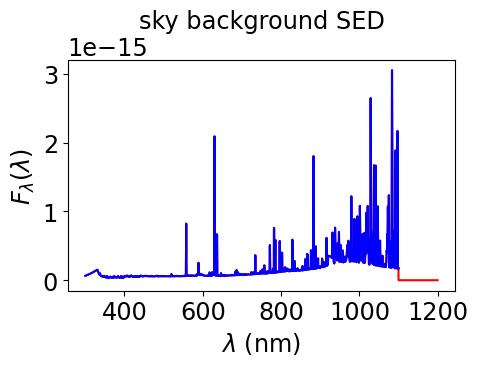

In [18]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(darksky.wavelen,darksky.flambda,'r-')
axs.plot(darksel.wavelen,darksel.flambda,'b-')
axs.set_title("sky background SED")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_ylabel("$F_\lambda (\lambda)$")

## Chose a Standard atmosphere

In [19]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.0# Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [20]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

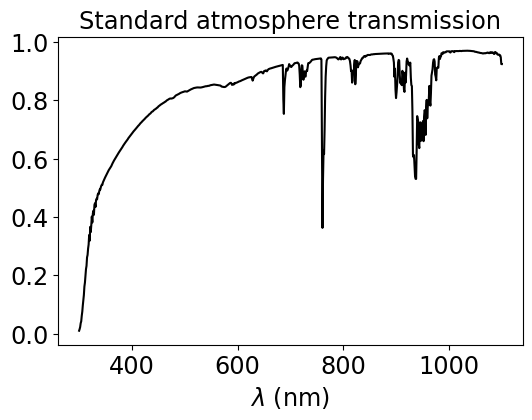

In [21]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

## Pickup an SED

In [22]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [23]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['stars' ,'white_dwarf'] 
sedtypes_not_used = ['sn','stars' ,'white_dwarf','galaxies', 'photoZ_outliers' ,'quasar']
sedtypes = sedtypes 

NSEDTYPES = len(sedtypes)

# dictionnary indexed by sed-name
seds = {}      # dictionnary that will contain the `rubin_sim` seds-Flambdas
sedsfnu = {}   # dictionnary that will contain the `rubin_sim` seds-Fnu
sedtypeslists = {}  # dictionnary that contain the SED type
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].read_sed_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        


In [24]:
df_SED=df_SED.set_index('name')
df_SED

type
name                           
km10_5250.fits_g45        stars
km10_4500.fits_g45        stars
km10_6000.fits_g45        stars
km10_7250.fits_g45        stars
km10_6500.fits_g45        stars
wd_He_5500_80       white_dwarf
wd_H_5500_80        white_dwarf
wd_He_15000_80      white_dwarf
wd_H_50000_80       white_dwarf
wd_He_10000_80      white_dwarf
wd_H_100000_80      white_dwarf
wd_H_15000_80       white_dwarf

In [25]:
renorm_mag_inZ = 10

all_selected_sed = []
all_tag_sed = []

for key in df_SED.index:
  
    
    the_sed = copy.deepcopy(seds[key])
       
    flux_norm = the_sed.calc_flux_norm(renorm_mag_inZ, pc.bandpass_total_std['z'])
    the_sed.multiply_flux_norm(flux_norm)
        
    the_sed_name = key
    all_selected_sed.append(the_sed)
    all_tag_sed.append(the_sed_name)
          

In [26]:
sed_flat = Sed()
sed_flat.set_flat_sed()
flux_norm = sed_flat.calc_flux_norm(renorm_mag_inZ , pc.bandpass_total_std['z'])
sed_flat.multiply_flux_norm(flux_norm)

all_selected_sed.append(sed_flat) 
all_tag_sed.append('flat')

In [27]:
NSEDSEL = len(all_selected_sed)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSEDSEL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEDSEL), alpha=1)

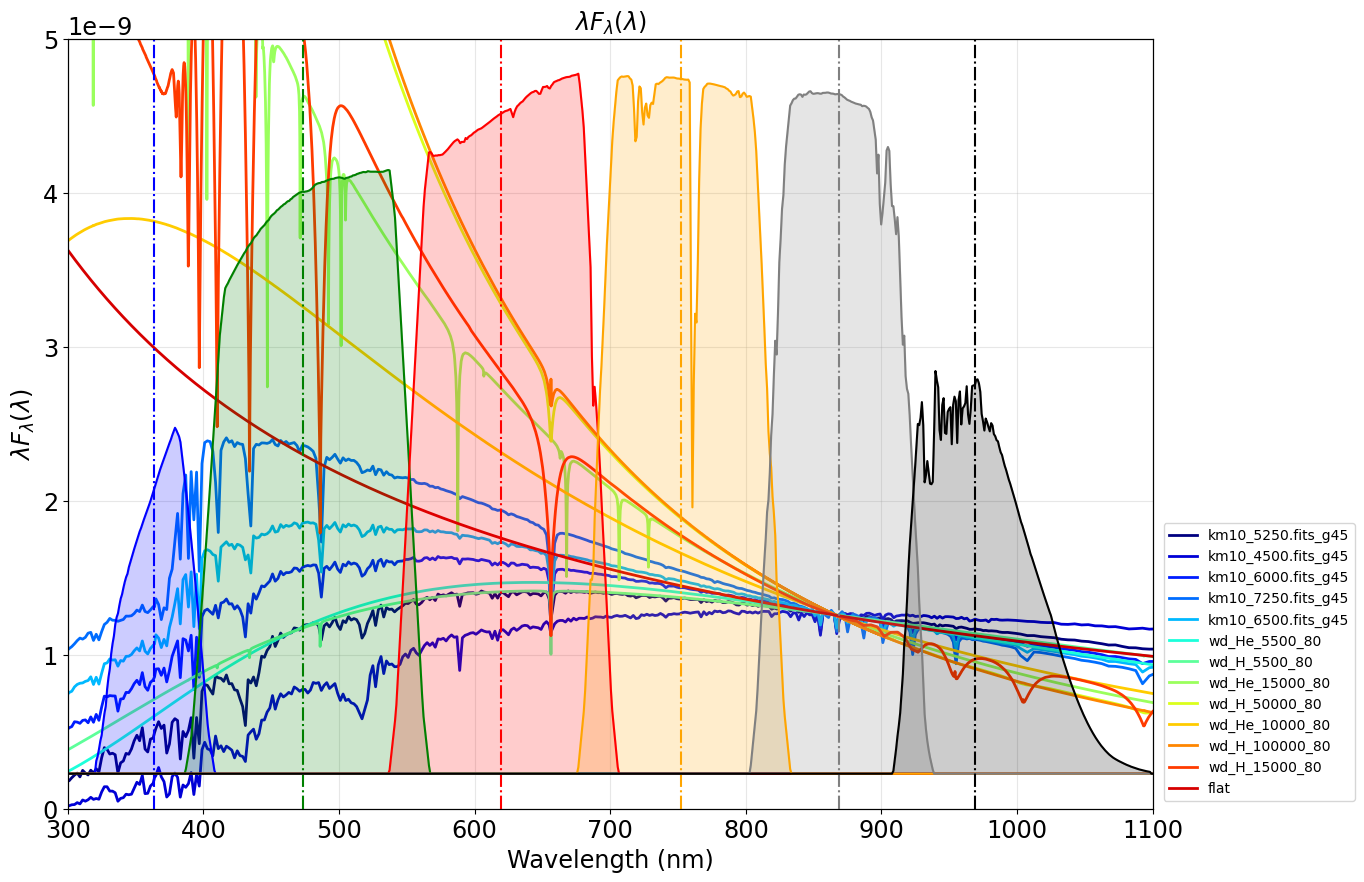

In [28]:
fig, ax = plt.subplots(1,1,figsize=(14,10))
all_flmax = np.zeros(NSEDSEL)


for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    ax.plot(the_sed.wavelen, the_sed.flambda * the_sed.wavelen,"-",color=all_colors[idx],label=all_tag_sed[idx],lw=2)
    #idx_inrange = np.where(np.logical_and(the_sed.flambda>=WLMIN, the_sed.flambda<WLMAX))[0]
    #flinrange = (the_sed.flambda * the_sed.wavelen)[idx_inrange]
    #all_flmax[idx] = np.max(flinrange)
    
ax.set_ylim(0,5e-9)    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\lambda F_\lambda(\lambda)$")
ax.set_title("$\lambda F_\lambda(\lambda)$")
ax2 = ax.twinx()

for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])

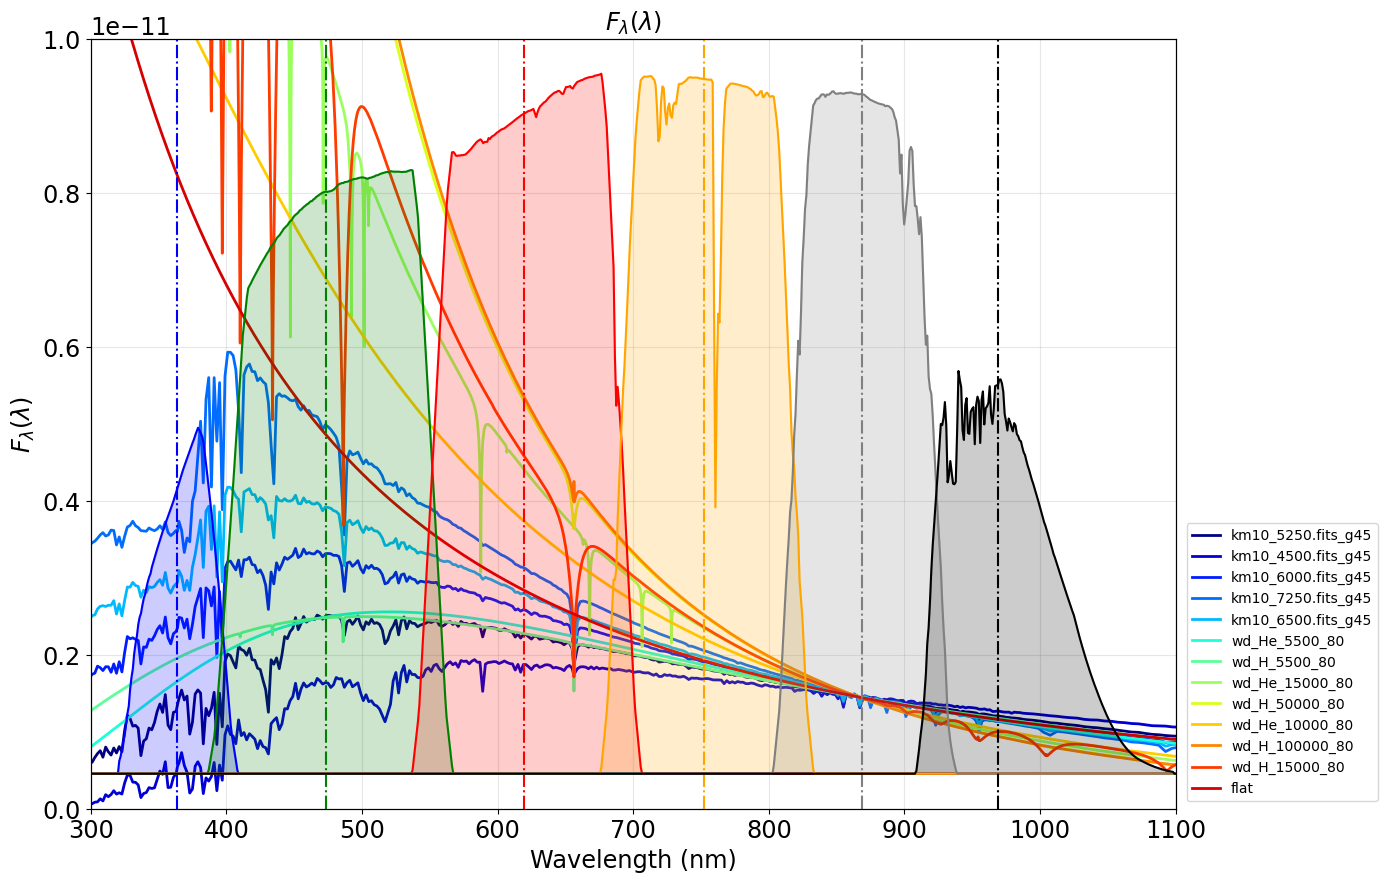

In [29]:
fig, ax = plt.subplots(1,1,figsize=(14,10))


for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    ax.plot(the_sed.wavelen, the_sed.flambda ,"-",color=all_colors[idx],label=all_tag_sed[idx],lw=2)
    #idx_inrange = np.where(np.logical_and(the_sed.flambda>=WLMIN, the_sed.flambda<WLMAX))[0]
    #flinrange = (the_sed.flambda * the_sed.wavelen)[idx_inrange]
    #all_flmax[idx] = np.max(flinrange)

    
ax.set_ylim(0,1e-11)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\lambda(\lambda)$")
ax.set_title("$F_\lambda (\lambda)$")
ax2 = ax.twinx()

for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

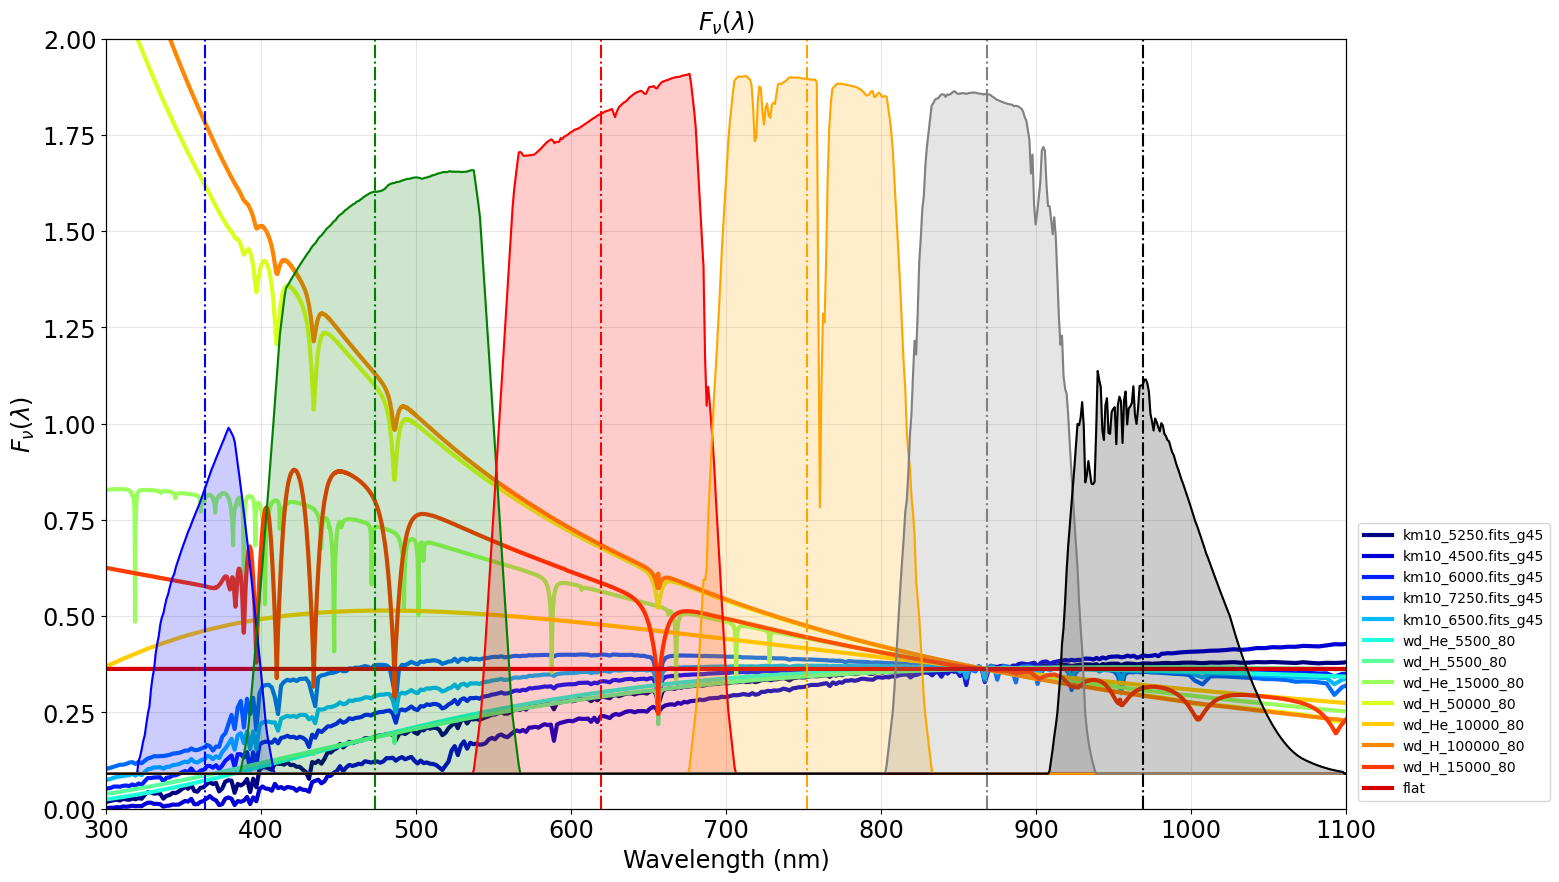

In [30]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(16,10))
for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    wavel,fnu = the_sed.get_sed_fnu()
    ax.plot(wavel, fnu,"-",color=all_colors[idx],label=all_tag_sed[idx],lw=3)


ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
flmax = np.max(fnu[indexes_sel])
ax.set_ylim(0,2e0)
                       

ax2 = ax.twinx()
for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

# Usefull photometric values from rubin_sim

In [31]:
photoparams = set_photometric_parameters(15, 2 , readnoise=None)

In [32]:
# constant in zero point
F0AB = 3631*(1*u.Jy).cgs.value
Z0PTconst = 2.5*np.log10((F0AB*photoparams.effarea*photoparams.nexp*photoparams.exptime)/(photoparams.gain*const.h.cgs.value))

z0pt_std= {}
for index,f in enumerate(filter_tagnames):
    z0pt_std[f] = Z0PTconst + 2.5*np.log10(pc.all_II0_std[f])
pd.DataFrame(z0pt_std, index=["z0pt_std"]).T    

z0pt_std
u  29.723683
g  31.132372
r  30.927937
i  30.637975
z  30.240657
y  29.446766

# 1) Demo that Gaussian Basis Function Regression  method can be used to fit a SED

## Fit Gaussian Basis Function

In [33]:
from astroML.linear_model import BasisFunctionRegression

/Users/dagoret/anaconda3/envs/conda_py310/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [34]:
FILTERWL

array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

In [35]:
wl0 = FILTERWL[:,2]
wl0

array([363.59690349, 473.54069923, 619.49926767, 752.01084117,
       868.488419  , 969.10570859])

In [36]:
index = 0
the_sed = all_selected_sed[index]
the_sed_name = os.path.basename(the_sed.name)
wavel,fnu = the_sed.get_sed_fnu()

In [37]:
func = interpolate.interp1d(wavel,fnu)
fl0=func(wl0)
efl0 = 0.05*fl0

In [38]:
# try several config, here 6 gaussians
nGaussians = 6
WLMIN = 300.  # high enough to avoid oscillations
WLMAX = 1100.
def FitGaussianBasisFunctionRegression(wl0,fl0,efl0,wlfit):
    """
    Fit a Gaussian Basis Functionon SED

    Parameter:
      wl0 : wavelength points
      fl0 : flux points
      wlfit : wavelenth over which fit results are evaluated
      scale : kernel scale length (hyper parameter to be optimized on a whole set of SED)
      scalemin,scalemax boundaries of scale 
      
    """

    basis_mu = np.linspace(WLMIN, WLMAX, nGaussians)[:, None]
    basis_sigma = 3 * (basis_mu[1] - basis_mu[0])

    gauss_basis = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
    
    gauss_basis.fit(wl0[:,None], fl0, efl0)
    mu_fit_gauss = gauss_basis.predict(wlfit[:, None])
    
    return  mu_fit_gauss

In [39]:
yfit = FitGaussianBasisFunctionRegression(wl0,fl0,efl0,wlfit=wavel)

In [40]:
the_sed_approx = Sed(wavelen=wavel, fnu=yfit, name="fGBF_"+the_sed_name)
wls,fls = the_sed_approx.get_sed_fnu()

In [41]:
mag_true = {}
mag_approx = {}
mag_diff = {}

for index,f in enumerate(filter_tagnames):
    mag_true[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
    mag_approx[f] = the_sed_approx.calc_mag(pc.bandpass_total_std[f])
    mag_diff[f] = mag_true[f] - mag_approx[f]
    

In [42]:
mag_true

{'u': 12.021530036392162,
 'g': 10.79639331061662,
 'r': 10.254862304725574,
 'i': 10.067434028469657,
 'z': 10.000000000000002,
 'y': 9.960170542326306}

In [43]:
mag_approx

{'u': 11.974433975786383,
 'g': 10.723844754489717,
 'r': 10.25046887453378,
 'i': 10.070754510354748,
 'z': 10.027536714229631,
 'y': 9.950867360386608}

In [44]:
mag_diff

{'u': 0.047096060605779755,
 'g': 0.07254855612690392,
 'r': 0.0043934301917936125,
 'i': -0.003320481885090487,
 'z': -0.027536714229629666,
 'y': 0.009303181939698035}

In [45]:
mag_diff.values()

dict_values([0.047096060605779755, 0.07254855612690392, 0.0043934301917936125, -0.003320481885090487, -0.027536714229629666, 0.009303181939698035])

In [46]:
np.array(list(mag_diff.values()))[:,np.newaxis]

array([[ 0.04709606],
       [ 0.07254856],
       [ 0.00439343],
       [-0.00332048],
       [-0.02753671],
       [ 0.00930318]])

In [47]:
def PlotGaussianBasisFunctionRegressionFitResults(wlpoints,flpoints,the_sed,the_sedapprox):
    """
    Plot the result of the fit
    """

    # decode SED
    the_sed_name = os.path.basename(the_sed.name)
    wavel,fnu = the_sed.get_sed_fnu()
    wls,fls = the_sed_approx.get_sed_fnu()

    # plot
    fig, ax = plt.subplots(1,1,figsize=(14,8))
    ax.plot(wavel,fnu,'b-',lw=3,label="original SED")
    ax.plot(wlpoints,flpoints,marker="o",color="r",ms=15,lw=0,label="Data points to fit")
    ax.plot(wls,fls,'g-',lw=2,label="Gaussian Basis Function Regression approximation")
    ax.grid()
    ax.set_xlim(300, 1100)
    ymin=0
    ymax = fl0.max()*1.3
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("$F_\\nu (\lambda)$")
    ax.set_title("Gaussian Basis Function Regression Fit :: $F_\\nu (\lambda)$"+ f" : {the_sed_name}")
    ax.legend(loc="upper right")


    ax2 = ax.twinx()

    for index,f in enumerate(filter_tagnames):
    
        ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
        ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
        ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
        ax2.set_yticks([])

    plt.show()
    

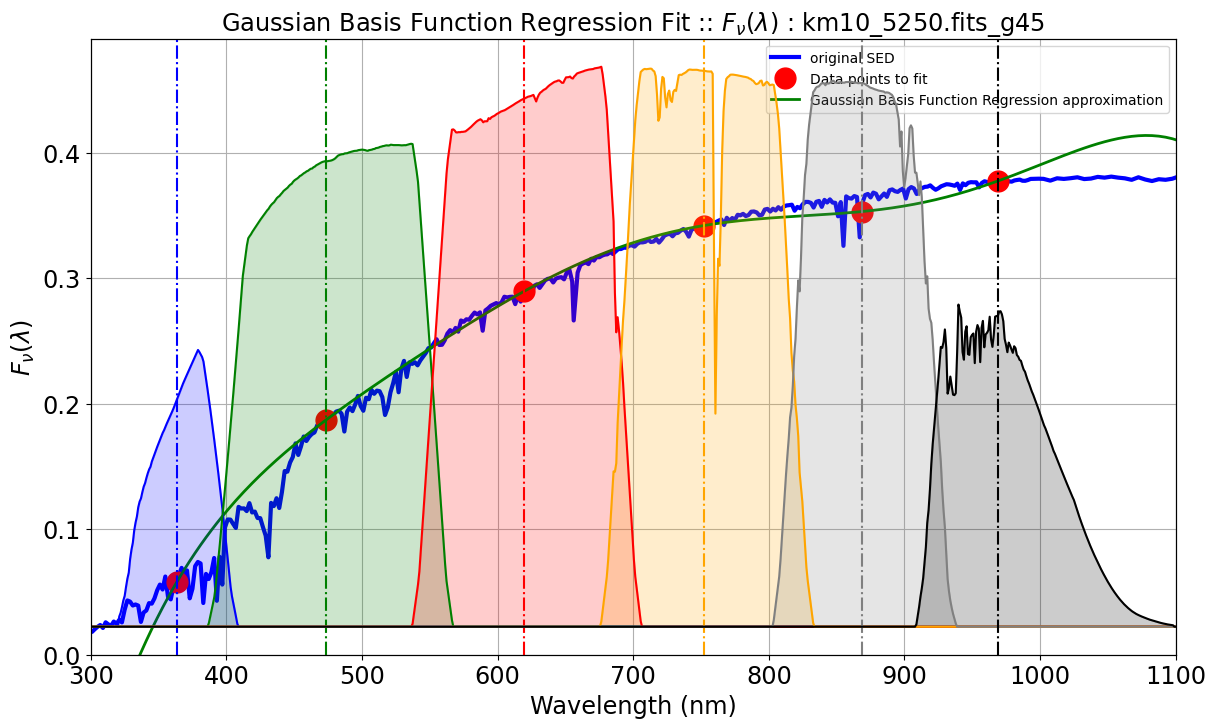

In [48]:
PlotGaussianBasisFunctionRegressionFitResults(wl0,fl0,the_sed,the_sed_approx)

------------------------------------------------------------------
km10_5250.fits_g45
{'u': 0.047096060605779755, 'g': 0.07254855612690392, 'r': 0.0043934301917936125, 'i': -0.003320481885090487, 'z': -0.027536714229629666, 'y': 0.009303181939698035}


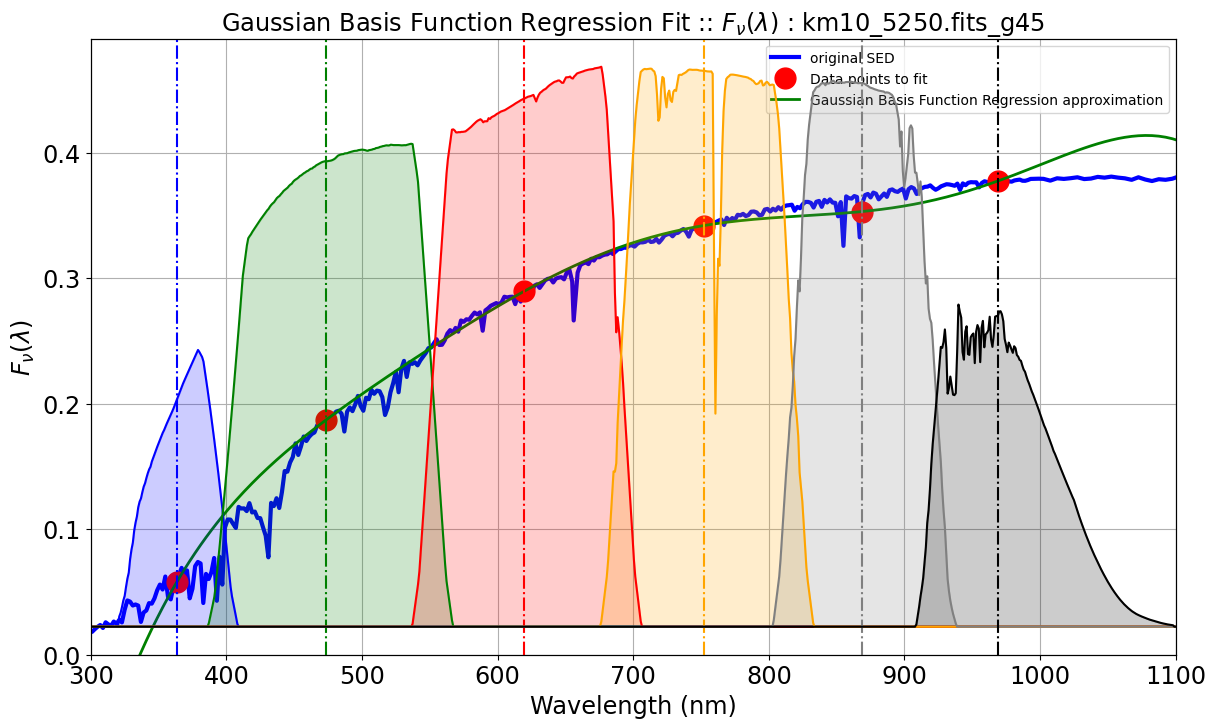

------------------------------------------------------------------
km10_4500.fits_g45
{'u': 0.19146950343657032, 'g': 0.13124929774672012, 'r': 0.00453677248768436, 'i': -0.003277779999004693, 'z': -0.042913731711118785, 'y': 0.011754777189002752}


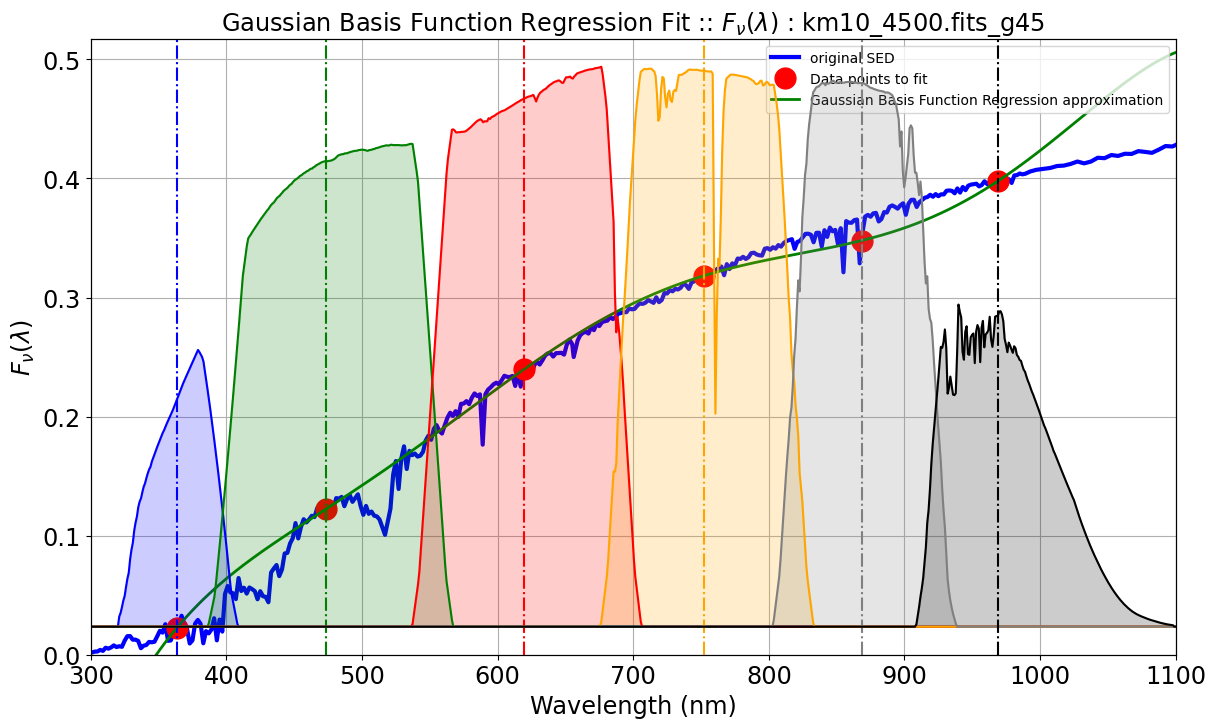

------------------------------------------------------------------
km10_6000.fits_g45
{'u': -0.05667015797399344, 'g': 0.03224788158385472, 'r': 0.0066574794005660465, 'i': -0.0024168866080191975, 'z': -0.017353860959852696, 'y': 0.004962968866967898}


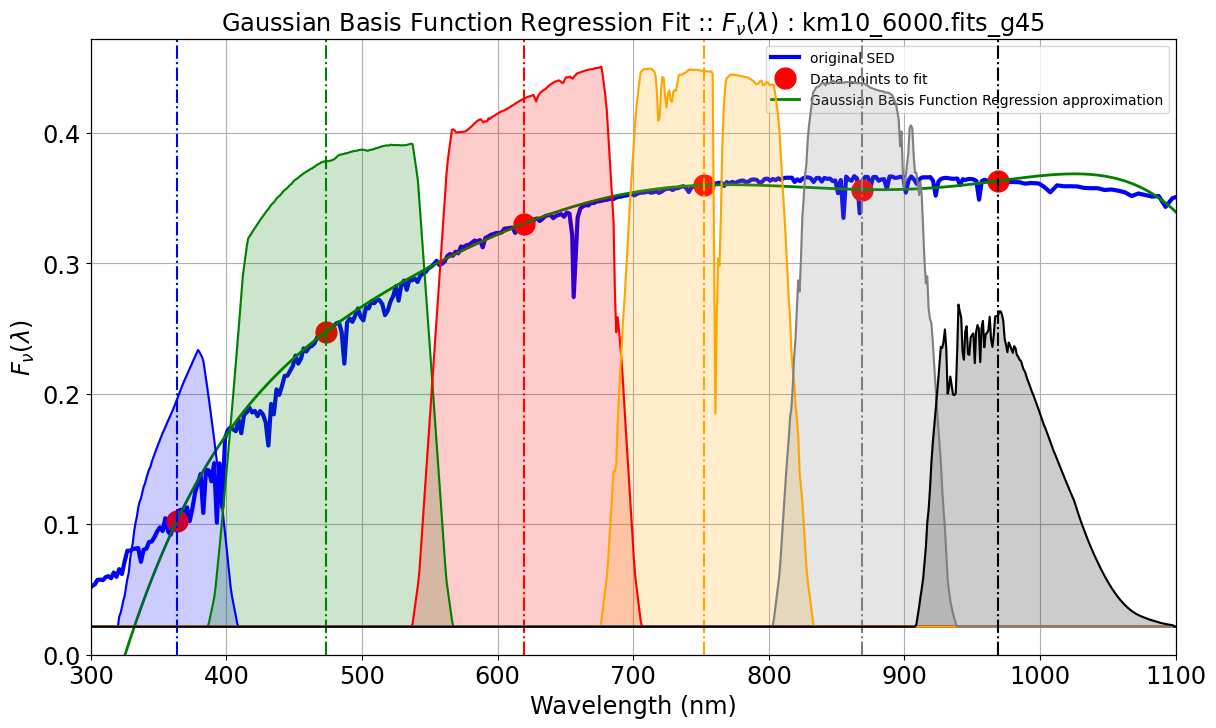

------------------------------------------------------------------
km10_7250.fits_g45
{'u': -0.1699000566678599, 'g': 0.011260146450137398, 'r': 0.010613779994711692, 'i': -0.0017799221662713194, 'z': -0.012364084130130237, 'y': 0.0054937047885808}


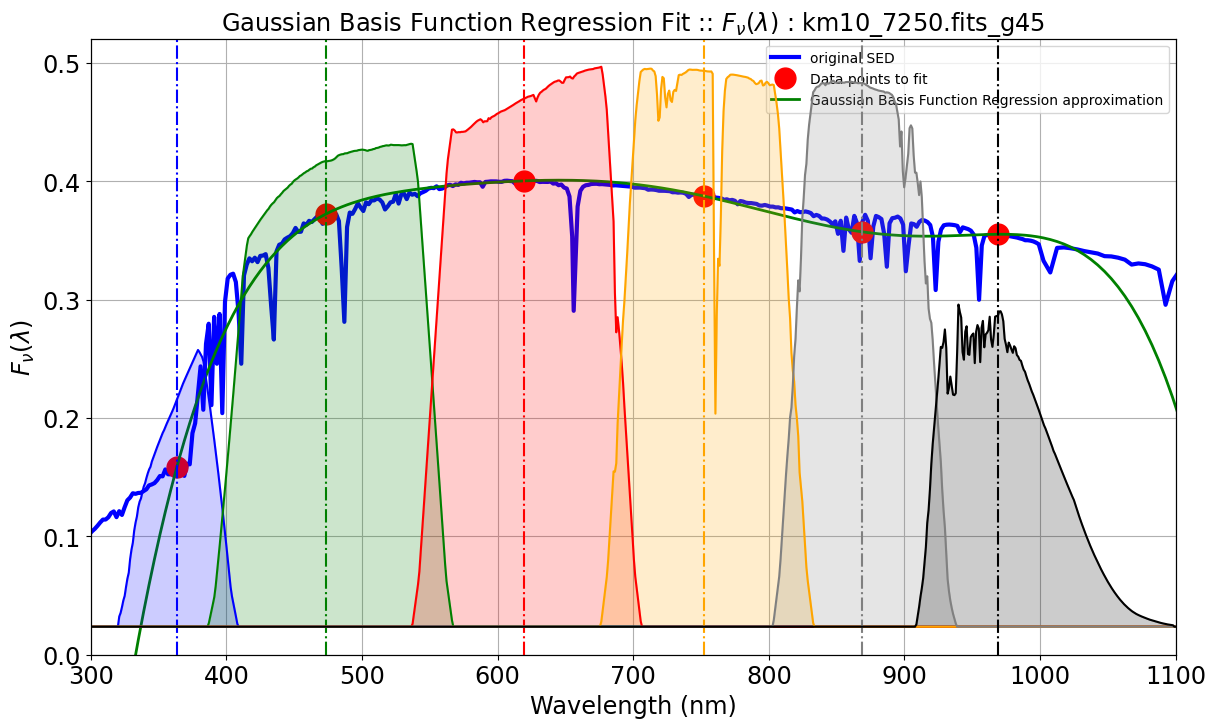

------------------------------------------------------------------
km10_6500.fits_g45
{'u': -0.10159847242306164, 'g': 0.018562033688091617, 'r': 0.008445745437342111, 'i': -0.0017569539179742577, 'z': -0.013914937224825508, 'y': 0.0036857827471177274}


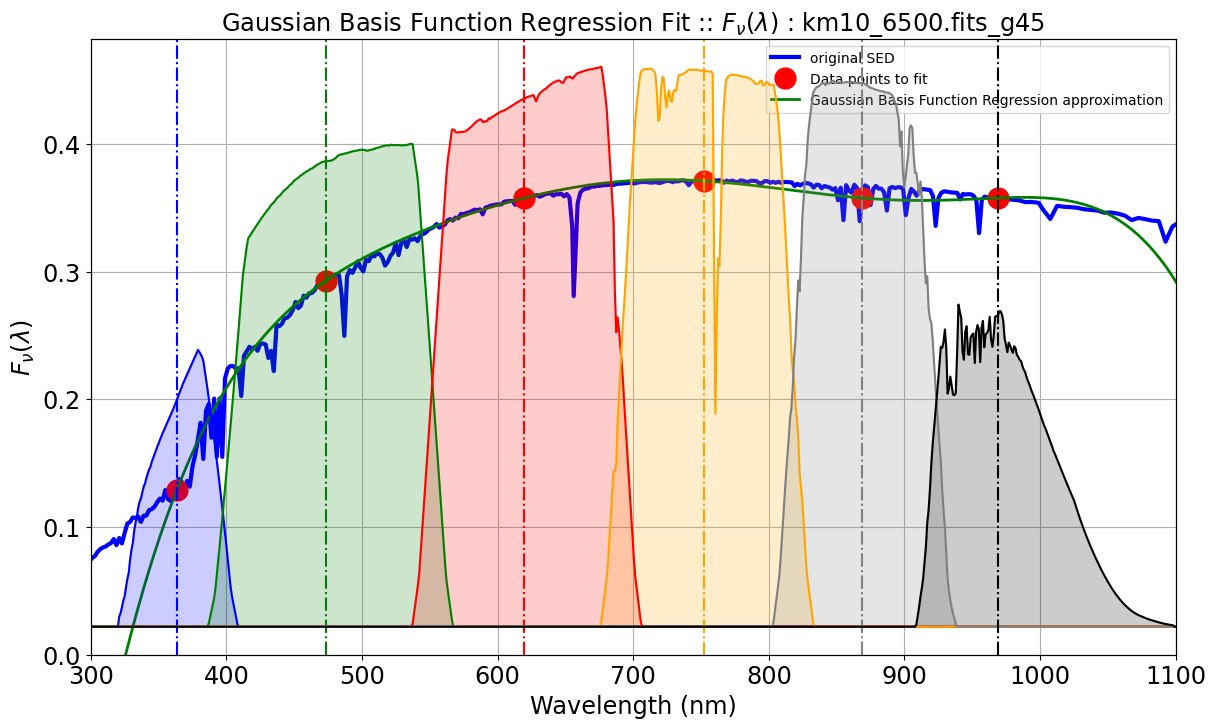

------------------------------------------------------------------
wd_He_5500_80.dat
{'u': -0.0003774998277741304, 'g': 0.0002675325141225926, 'r': -1.784550389949402e-05, 'i': -1.3595975691060858e-05, 'z': -0.0001228208878440995, 'y': 0.0022607204741955655}


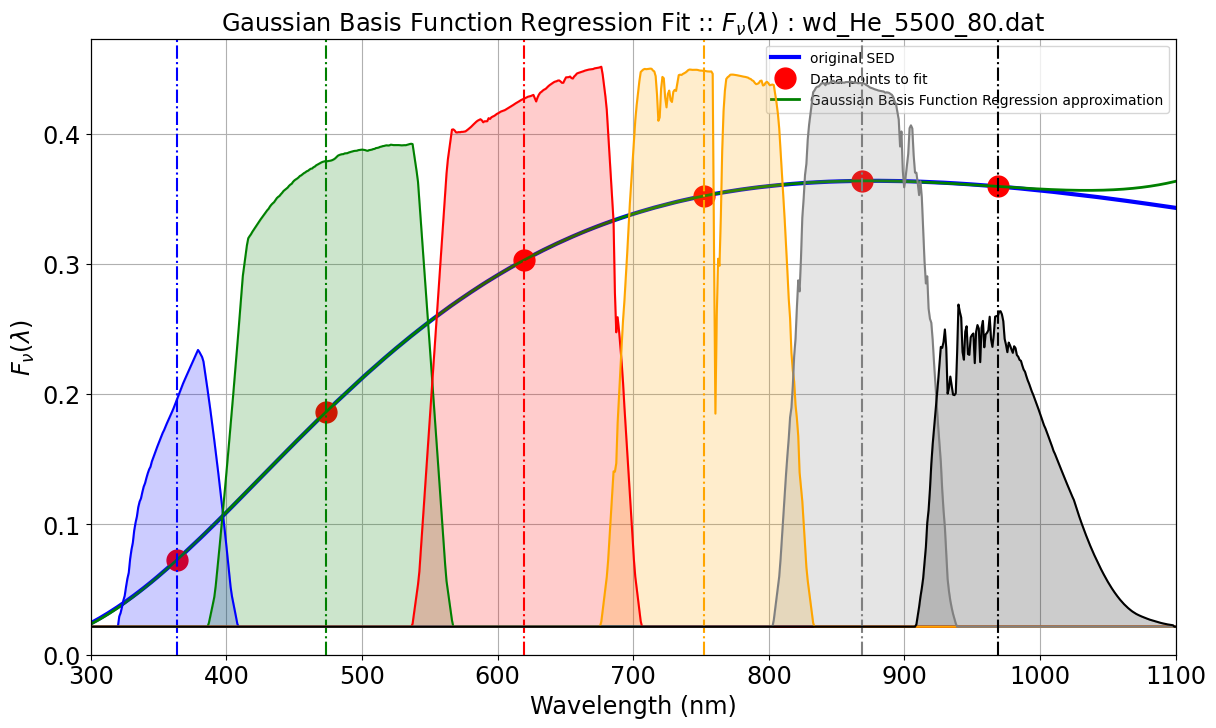

------------------------------------------------------------------
wd_H_5500_80.dat
{'u': -3.6787267577054195e-05, 'g': 0.001422930599959571, 'r': 0.002640340748820691, 'i': -6.0993637990947036e-05, 'z': -9.747379801972045e-05, 'y': 0.001212180834292198}


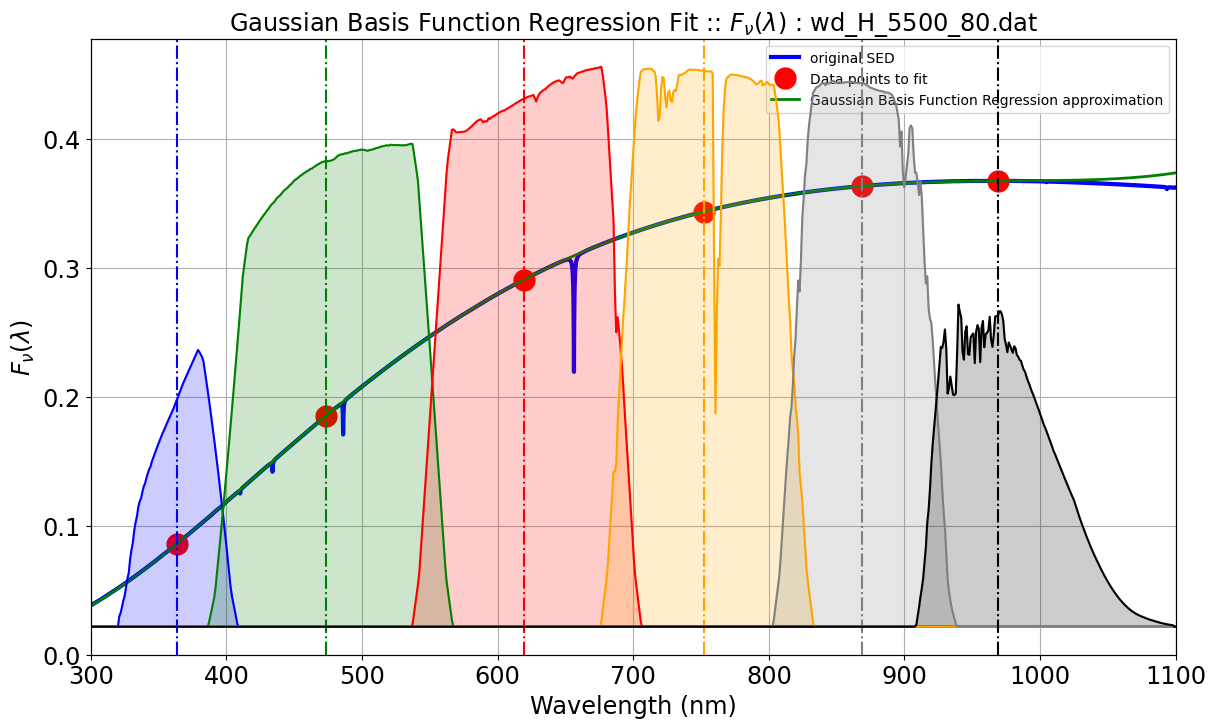

------------------------------------------------------------------
wd_He_15000_80.dat
{'u': -0.007352210425183969, 'g': 0.012956925624072468, 'r': 0.011231509282131569, 'i': 0.005070709930807382, 'z': 0.00021541692451165773, 'y': -0.009315395615207223}


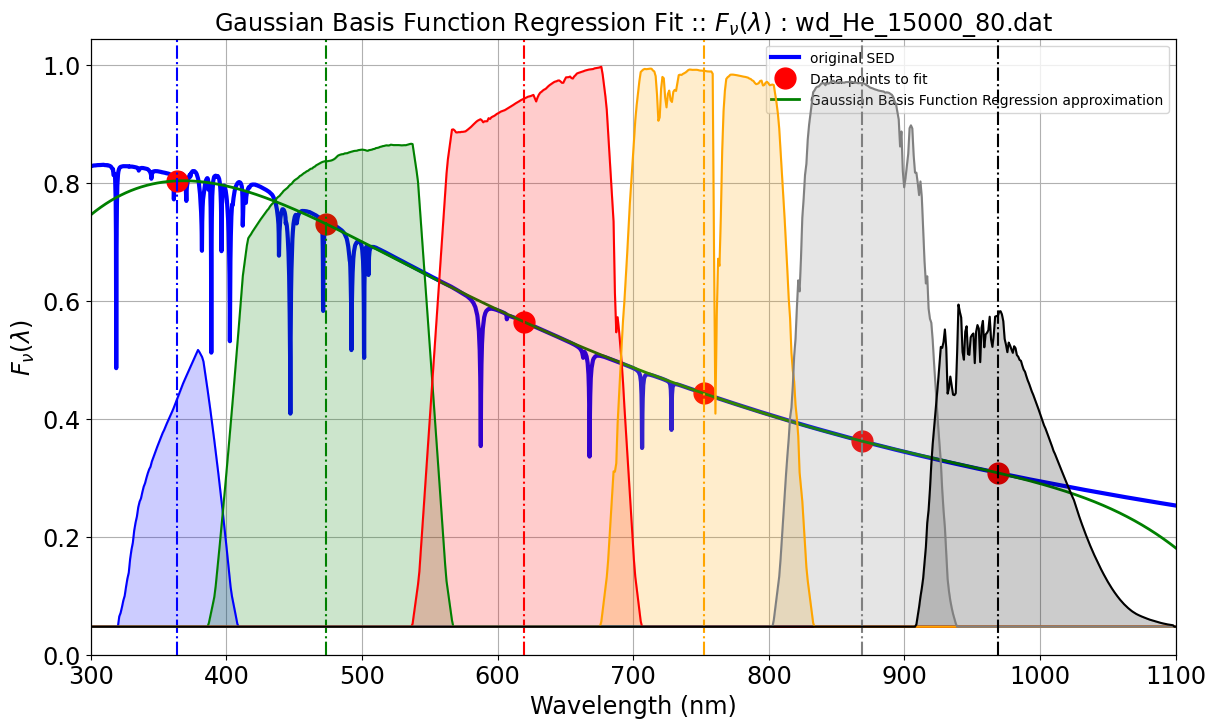

------------------------------------------------------------------
wd_H_50000_80.dat
{'u': -0.00184723861902647, 'g': 0.01598615535005976, 'r': 0.006217656155850904, 'i': -0.00011468566077255105, 'z': -0.0001300287156631441, 'y': 0.012659074289164352}


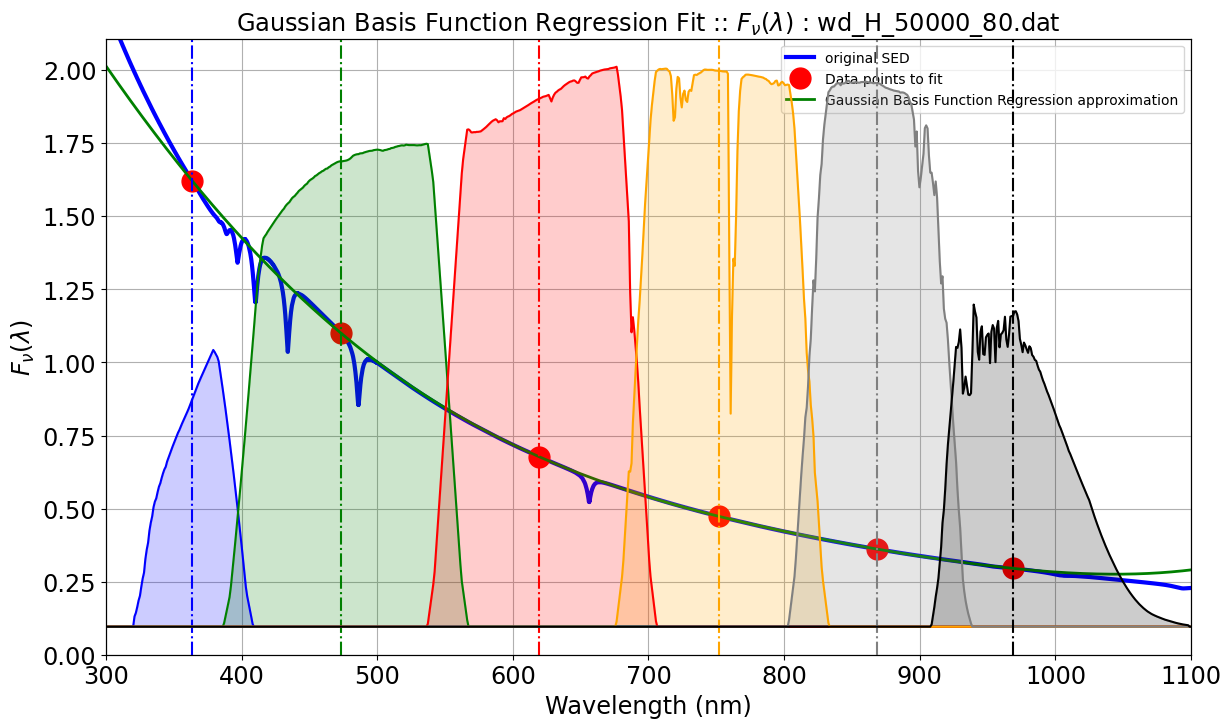

------------------------------------------------------------------
wd_He_10000_80.dat
{'u': -0.0005870692248262088, 'g': 0.00017429560294068835, 'r': -0.00013407619005612048, 'i': 2.5164246553188718e-05, 'z': 0.00017812473570089082, 'y': -0.006215027195771938}


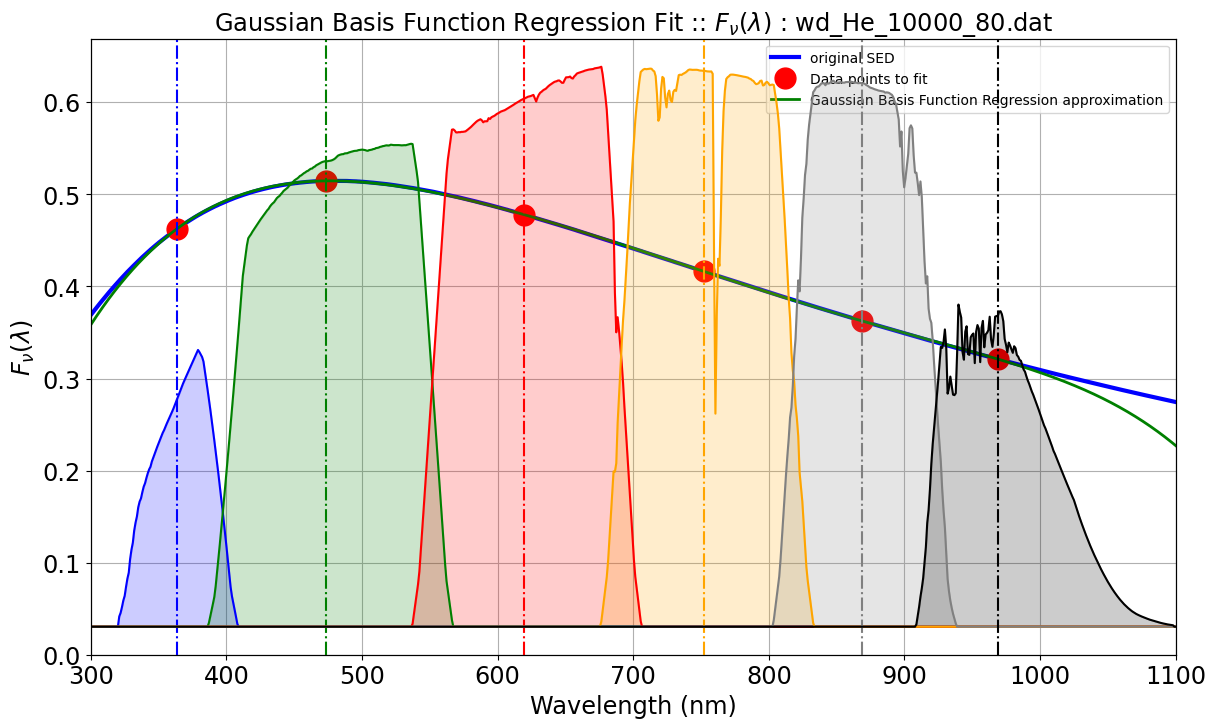

------------------------------------------------------------------
wd_H_100000_80.dat
{'u': -0.0008716019705943268, 'g': 0.0073146421005816364, 'r': 0.0026645149892328135, 'i': -0.00018611699043802332, 'z': -0.0009301133818730989, 'y': 0.025666727436087555}


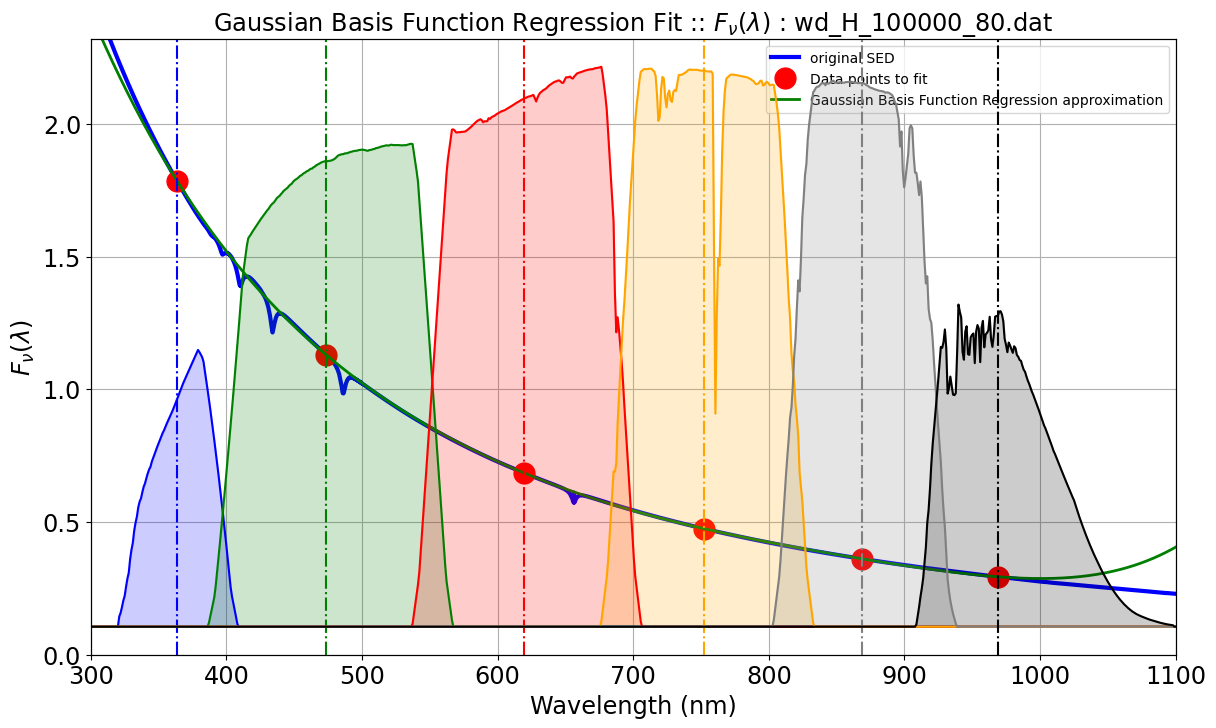

------------------------------------------------------------------
wd_H_15000_80.dat
{'u': -0.03511018247242781, 'g': 0.053482261161835964, 'r': 0.028532845611096036, 'i': -5.6670045402995584e-05, 'z': 0.001044393554087364, 'y': -0.02086297686232541}


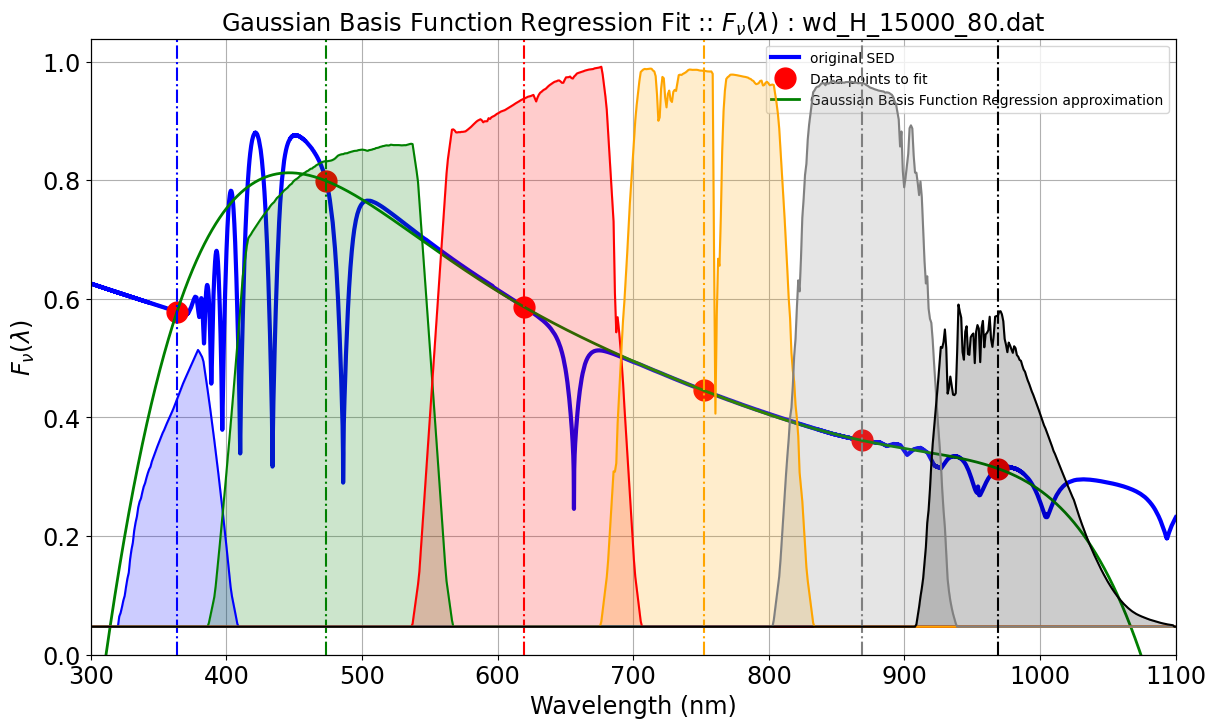

------------------------------------------------------------------
Flat
{'u': -1.0658141036401503e-14, 'g': 5.329070518200751e-15, 'r': -1.7763568394002505e-15, 'i': 0.0, 'z': 1.7763568394002505e-15, 'y': -6.217248937900877e-14}


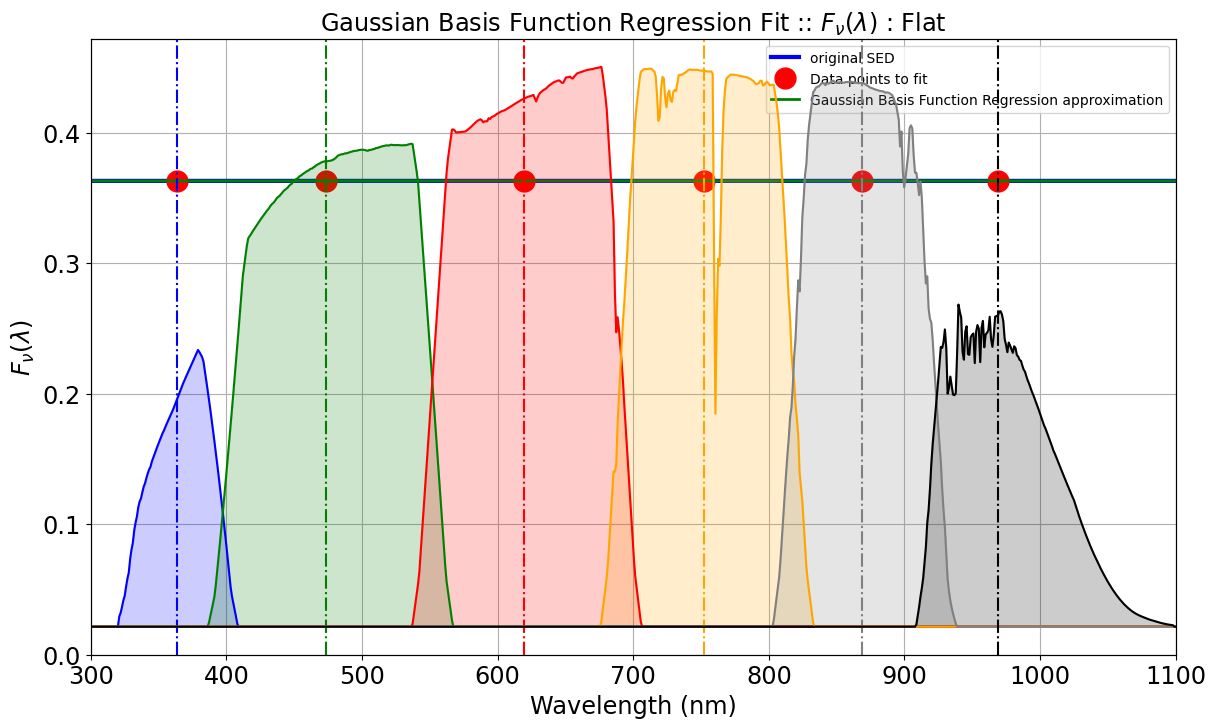

In [49]:
all_mag_true = []
all_mag_approx = []
all_mag_diff = []


for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    the_sed_name = os.path.basename(the_sed.name)
    wavel,fnu = the_sed.get_sed_fnu()
    func = interpolate.interp1d(wavel,fnu)
    fl0=func(wl0)
    efl0 = 0.05*fl0

    # does the fit
    yfit = FitGaussianBasisFunctionRegression(wl0,fl0,efl0,wlfit=wavel)
    
    # calculate the approximated SED
    the_sed_approx = Sed(wavelen=wavel, fnu=yfit, name="GBF_"+the_sed_name)

    # calculate the magnitudes
    mag_true = {}
    mag_approx = {}
    mag_diff = {}
    for index,f in enumerate(filter_tagnames):
        mag_true[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
        mag_approx[f] = the_sed_approx.calc_mag(pc.bandpass_total_std[f])
        mag_diff[f] = mag_true[f] - mag_approx[f]
    print("------------------------------------------------------------------")
    print(the_sed_name)
    print(mag_diff)
    
    all_mag_true.append(mag_true)
    all_mag_approx.append(mag_approx)
    all_mag_diff.append(mag_diff)
    
    # plot
    PlotGaussianBasisFunctionRegressionFitResults(wl0,fl0,the_sed,the_sed_approx)
    

# 2) Fits an SED from chi2 minimisation on magnitudes


- sometimes the fit fails --> must find why : are there some parameters to tune (init param, range )

In [50]:
class FitSEDMags:
    """
    Class to fit magnitudes
    """
    def __init__(self,passband):
        
        print("Init FitSEDMags")
        self.passband = passband

    
    def func_residuals(self,params,*args):
        """
        This function is called by the scipy.optimize.least_squares function to compute the normalized residuals
        at each data point at each wavelength (yi-f(xi,thetaj)/sigmai
    
        input:
          - params : the unknown atmospheric parameters to fit (pwv,oz)
          - *args  : additionnal data provided to compute the mode : 
                 to the model
                   1) the wavelength array, 
                   2) flux data : the measured fluxes
                   3) dataerr : the error on fluxes
                   4) the wavelength arry over which the sed of the model is computed.
                   
                
        return:
          - the array of residuals for the given set of parameters required by the least_squares function 
        """

       
        
        wlpoints = args[0]         # wavelength array required by the model function pred2 (x values) 
        mag_data = args[1]       # the observed mag array
        mag_dataerr = args[2]    # the error on the observed mag array
        wlrange = args[3]        # the wavelength range of the SED

        
        
        # compute the flux of the from the parameters proposed by the fitting procedure
        #flux_model = FitGaussianProcess(wlpoints,params,wlrange,scale=500.,scalemin=300.,scalemax=5000.)
        flux_model = FitGaussianBasisFunctionRegression(wlpoints,params,0.05*params,wlfit=wavel)
        # compute the model magnitudes
        the_sed_params = Sed(wavelen=wlrange, fnu=flux_model)

        # compute the residuals for each band
        residuals = {}
        mag_params = {}
        for index,f in enumerate(filter_tagnames):
            mag_params[f] = the_sed_params.calc_mag(pc.bandpass_total_std[f])
            residuals[f] = (mag_data[f] - mag_params[f])/mag_dataerr[f]  

        # transform the dictionary into a numpy array required by the calling function
        res = np.array(list(residuals.values()))
      
        
        return res


    def fit(self,params0,bounds,xdata,ydata,yerrdata,wlrange):
        """
        Fit 

        Function to call the fitting method 

        """

        # result from least_squares function
        res_fit = least_squares(self.func_residuals,params0,bounds=bounds,args=[xdata,ydata,yerrdata,wlrange])
               
        # decoding the output of the least_square fit and computing myself usefull quantities into a dictionary
        popt= res_fit.x
        J = res_fit.jac
        pcov = np.linalg.inv(J.T.dot(J))
        sigmas = np.sqrt(np.diagonal(pcov))
        cost=res_fit.cost
        residuals = res_fit.fun
        chi2=np.sum(residuals**2)
        ndeg = J.shape[0]- popt.shape[0]
        chi2_per_deg = chi2/ndeg
        
        fit_dict = {"chi2":chi2,"ndeg":ndeg,"chi2_per_deg":chi2_per_deg,"popt":popt,"sigmas":sigmas}

        # return both  res_fit and fit_dict
        return res_fit,fit_dict

In [51]:
def PlotSEDPointsFitResults(wlpoints,flpoints,the_sed,the_sedapprox):
    """
    """

    fig, ax = plt.subplots(1,1,figsize=(14,8))

    # decode SED
    the_sed_name = os.path.basename(the_sed.name)
    wavel,fnu = the_sed.get_sed_fnu()
    wls,fls = the_sed_approx.get_sed_fnu()

    #plot    
    ax.plot(wavel,fnu,'b-',lw=3,label="original SED")
    ax.plot(wlpoints,flpoints,marker="o",color="r",ms=10,lw=0,label="SED Points fitted")
    ax.plot(wls,fls ,'r--',lw=2,label="Gaussian Basis Function Regression fit approximation")


    ax.grid()
    ax.set_xlim(300, 1100)
    ymin=0
    ymax = fit_dict["popt"].max()*1.3
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("$F_\\nu (\lambda)$")
    ax.set_title("Fit SED from magnitudes (chi2 minim): $F_\\nu (\lambda)$"+ f" : {the_sed_name}")
    ax.legend(loc="upper right")


    ax2 = ax.twinx()

    for index,f in enumerate(filter_tagnames):
    
        ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
        ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
        ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
        ax2.set_yticks([])

    plt.show()

### Select the SED

In [52]:
# the flat SED is used to compute init parameters
the_sedflat = all_selected_sed[-1]

In [53]:
# select one SED
index = 0
the_sed = all_selected_sed[index]
the_sed_name = os.path.basename(the_sed.name)
wavel,fnu = the_sed.get_sed_fnu()

In [54]:
the_sed_name 

'km10_5250.fits_g45'

## initialize the fit object with the passband

In [55]:
the_fit = FitSEDMags(pc.bandpass_total_std)

Init FitSEDMags


## Calculate the data

- here the magnitudes that would be in a catalog for the object under investigation

In [56]:
mag_true = {}
mag_flat = {}

for index,f in enumerate(filter_tagnames):
    mag_true[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
    mag_flat[f] = the_sedflat.calc_mag(pc.bandpass_total_std[f])


### provide the errors on the data

- these errors would allow to compute the errors on the fitted flux

In [57]:
mag_true_err = {"u": 0.01, "g": 0.01, "r": 0.01, "i": 0.01, "z": 0.01, "y": 0.01}

### Extract the init values of the parameters to fit on the flat spectrum

In [58]:
wavel_flat,fnu_flat = the_sedflat.get_sed_fnu()
func = interpolate.interp1d(wavel_flat,fnu_flat)
fl0=func(wl0)
params0 = fl0

### Need the bounds on the parameters

- this range matters for the fit sucess (many failures with this range is too high or tow small)
- it is probably easy to assess the good range. 

In [59]:
bounds = (fl0/100.,fl0*100.)

## Call the fit

- often the fit fails
- - check if wrong initialisations,..

In [60]:
xdata = wl0
ydata = mag_true
ydataerr = mag_true_err

res_fit,fit_dict = the_fit.fit(params0 = params0 ,bounds = bounds,xdata = xdata ,ydata = mag_true ,yerrdata=ydataerr,wlrange=wavel)


/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


In [61]:
print("Fit Results :: ",res_fit,fit_dict )

Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.954e-12  1.954e-12  1.243e-12  1.243e-12  5.329e-13
                8.882e-13]
           x: [ 5.378e-02  1.741e-01  2.889e-01  3.424e-01  3.634e-01
                3.758e-01]
        cost: 5.900679571053168e-24
         jac: [[ 1.946e+03 -1.504e+02 ...  1.961e+02 -5.134e+01]
               [ 3.646e+01  5.488e+02 ... -1.651e+01  4.729e+00]
               ...
               [-4.986e-01  1.559e+00 ...  2.708e+02  1.355e+01]
               [ 1.287e+01 -3.544e+01 ... -7.066e+01  3.297e+02]]
        grad: [-3.721e-09  1.356e-09 -6.786e-11  1.068e-09 -3.046e-10
                4.065e-10]
  optimality: 1.3490222659476655e-07
 active_mask: [0 0 0 0 0 0]
        nfev: 9
        njev: 9 {'chi2': 1.1801359142106337e-23, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.05378351, 0.17414193, 0.2889431 , 0.34239903, 0.36337187,
       0.37584051]), 'sigmas': array([0.00105682

### Once the fit is performed , get the model shape from the gaussian basis function 

In [62]:
#yfit = FitGaussianProcess(wl0,fit_dict["popt"],wlfit=wavel)
yfit = FitGaussianBasisFunctionRegression(wl0,fit_dict["popt"],0.05*fit_dict["popt"],wlfit=wavel)
# calculate the approximated SED
the_sed_approx = Sed(wavelen=wavel, fnu=yfit, name="GBFv2_"+the_sed_name)

## Compare the true SED with the fitted SED

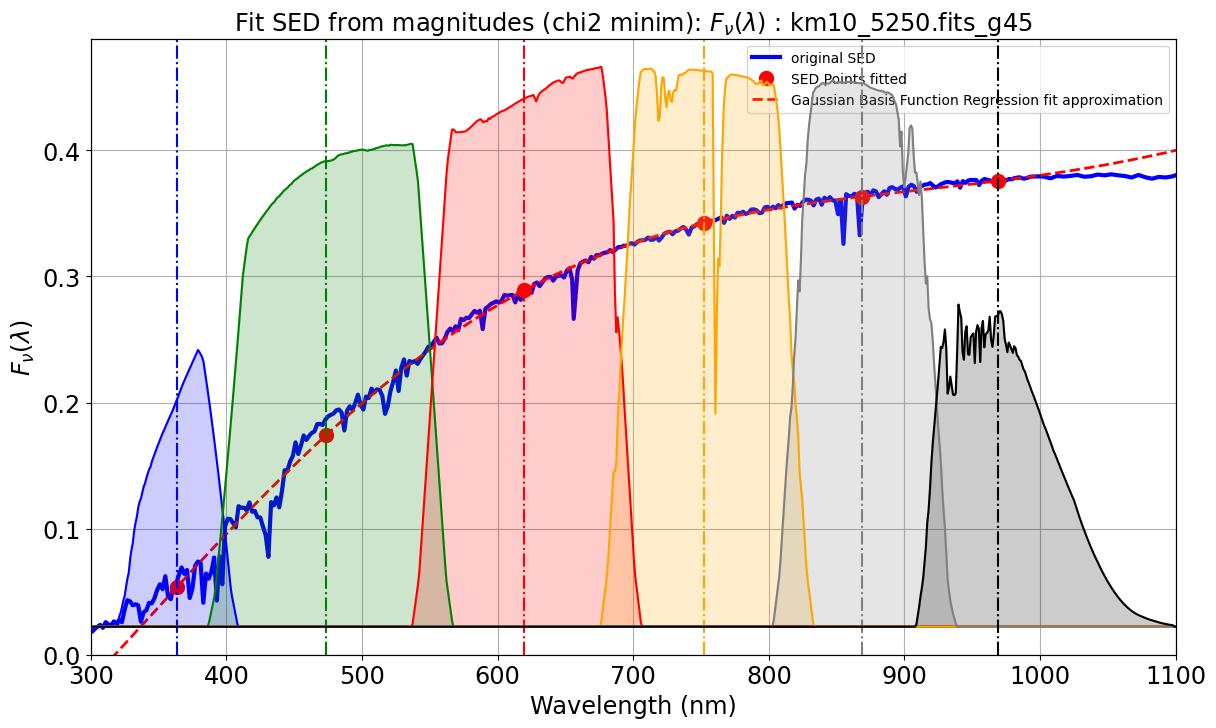

In [63]:
PlotSEDPointsFitResults(wl0,fit_dict["popt"],the_sed,the_sed_approx)

## Do the fit on all Spectra and plot

SED :  km10_5250.fits_g45 Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.954e-12  1.954e-12  1.243e-12  1.243e-12  5.329e-13
                8.882e-13]
           x: [ 5.378e-02  1.741e-01  2.889e-01  3.424e-01  3.634e-01
                3.758e-01]
        cost: 5.900679571053168e-24
         jac: [[ 1.946e+03 -1.504e+02 ...  1.961e+02 -5.134e+01]
               [ 3.646e+01  5.488e+02 ... -1.651e+01  4.729e+00]
               ...
               [-4.986e-01  1.559e+00 ...  2.708e+02  1.355e+01]
               [ 1.287e+01 -3.544e+01 ... -7.066e+01  3.297e+02]]
        grad: [-3.721e-09  1.356e-09 -6.786e-11  1.068e-09 -3.046e-10
                4.065e-10]
  optimality: 1.3490222659476655e-07
 active_mask: [0 0 0 0 0 0]
        nfev: 9
        njev: 9 {'chi2': 1.1801359142106337e-23, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.05378351, 0.17414193, 0.2889431 , 0.34239903, 0.36337187,
       0.37584051]), '

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


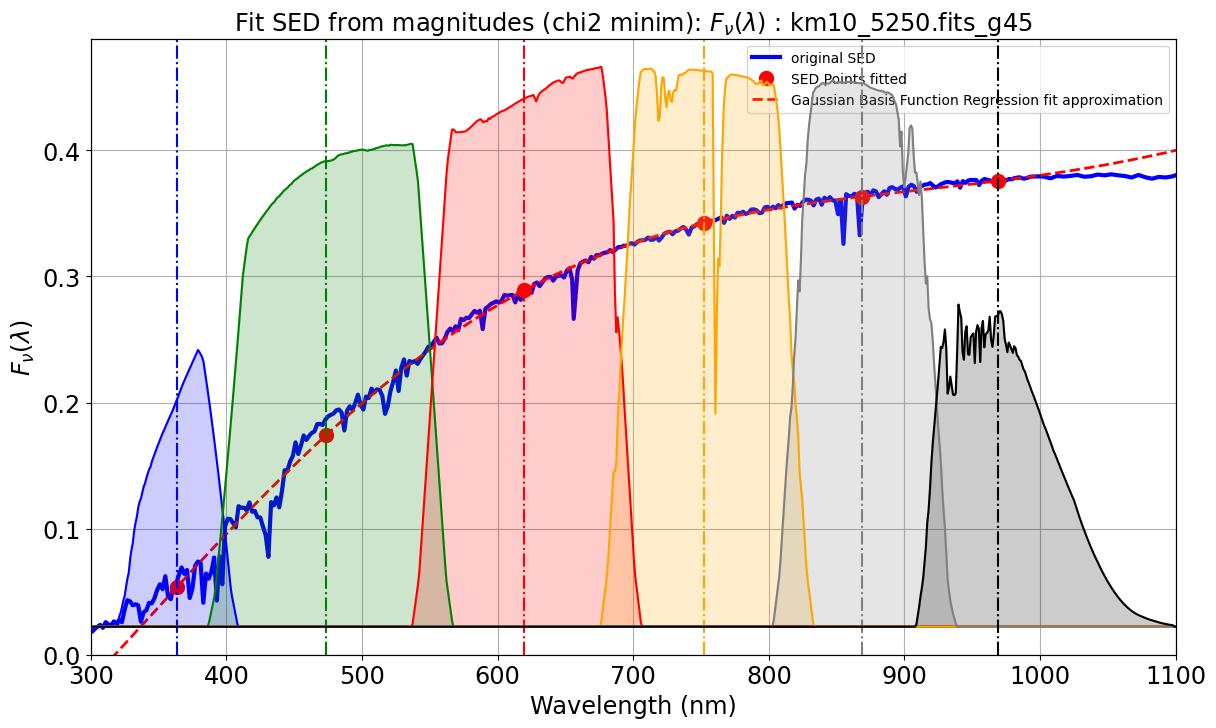

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  km10_4500.fits_g45 Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.949e-11  1.535e-10  7.425e-11  2.842e-12  7.283e-12
                1.528e-11]
           x: [ 1.623e-02  1.072e-01  2.393e-01  3.181e-01  3.636e-01
                3.962e-01]
        cost: 1.5116294660807968e-20
         jac: [[ 5.687e+03 -4.395e+02 ...  5.733e+02 -1.501e+02]
               [ 5.769e+01  8.682e+02 ... -2.612e+01  7.488e+00]
               ...
               [-4.950e-01  1.559e+00 ...  2.708e+02  1.355e+01]
               [ 1.216e+01 -3.346e+01 ... -6.671e+01  3.113e+02]]
        grad: [-1.588e-07  1.474e-07  1.162e-08  3.570e-08 -1.972e-08
                1.033e-08]
  optimality: 5.763104053086691e-06
 active_mask: [0 0 0 0 0 0]
        nfev: 10
        njev: 9 {'chi2': 3.0232589321615936e-20, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.0162301 , 0.10721936, 0.23934432, 0.31805046, 0.36358346,
       0.39622096]), 

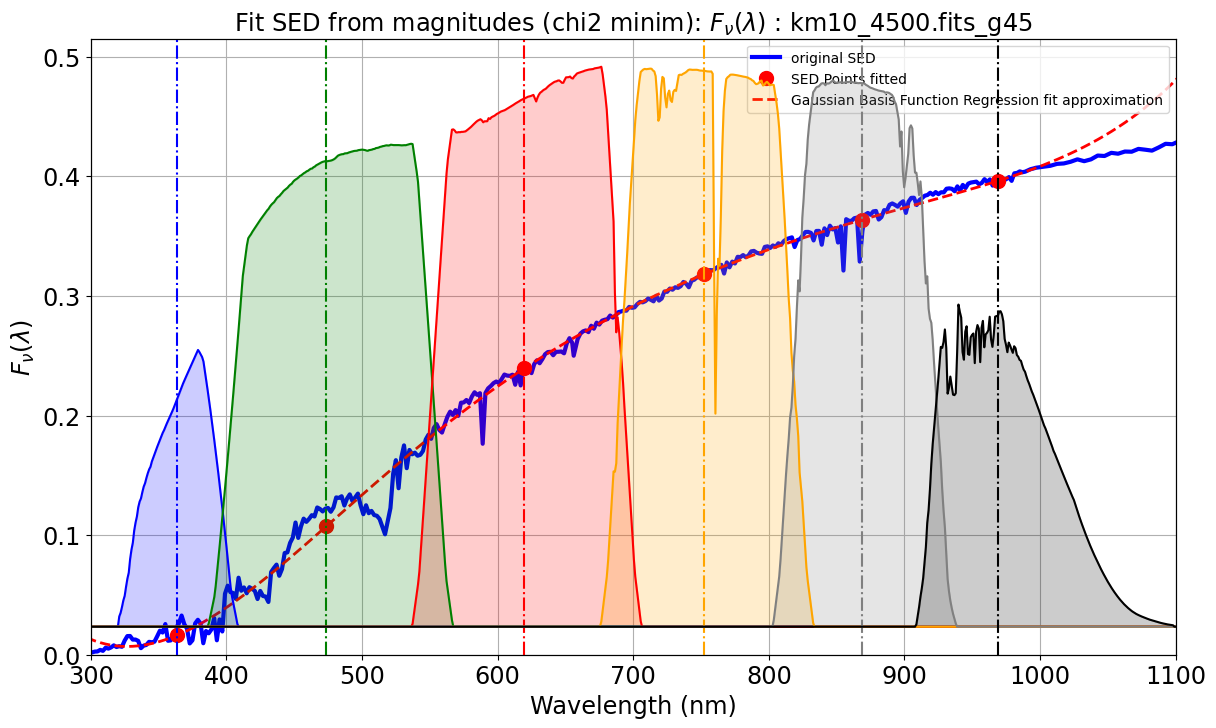

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  km10_6000.fits_g45 Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.132e-11 -1.705e-11 -7.816e-12 -5.826e-11 -6.413e-11
               -5.080e-11]
           x: [ 1.074e-01  2.396e-01  3.287e-01  3.605e-01  3.631e-01
                3.624e-01]
        cost: 5.4471318822054e-21
         jac: [[ 1.005e+03 -7.770e+01 ...  1.013e+02 -2.653e+01]
               [ 2.676e+01  4.028e+02 ... -1.211e+01  3.474e+00]
               ...
               [-4.950e-01  1.562e+00 ...  2.708e+02  1.355e+01]
               [ 1.341e+01 -3.691e+01 ... -7.360e+01  3.434e+02]]
        grad: [ 2.032e-08 -6.760e-09 -2.067e-09 -2.140e-08 -1.247e-08
               -1.885e-08]
  optimality: 7.691600744698807e-07
 active_mask: [0 0 0 0 0 0]
        nfev: 7
        njev: 7 {'chi2': 1.08942637644108e-20, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.1074124 , 0.23961032, 0.32874455, 0.36050148, 0.36312199,
       0.36238414]), 'sigma

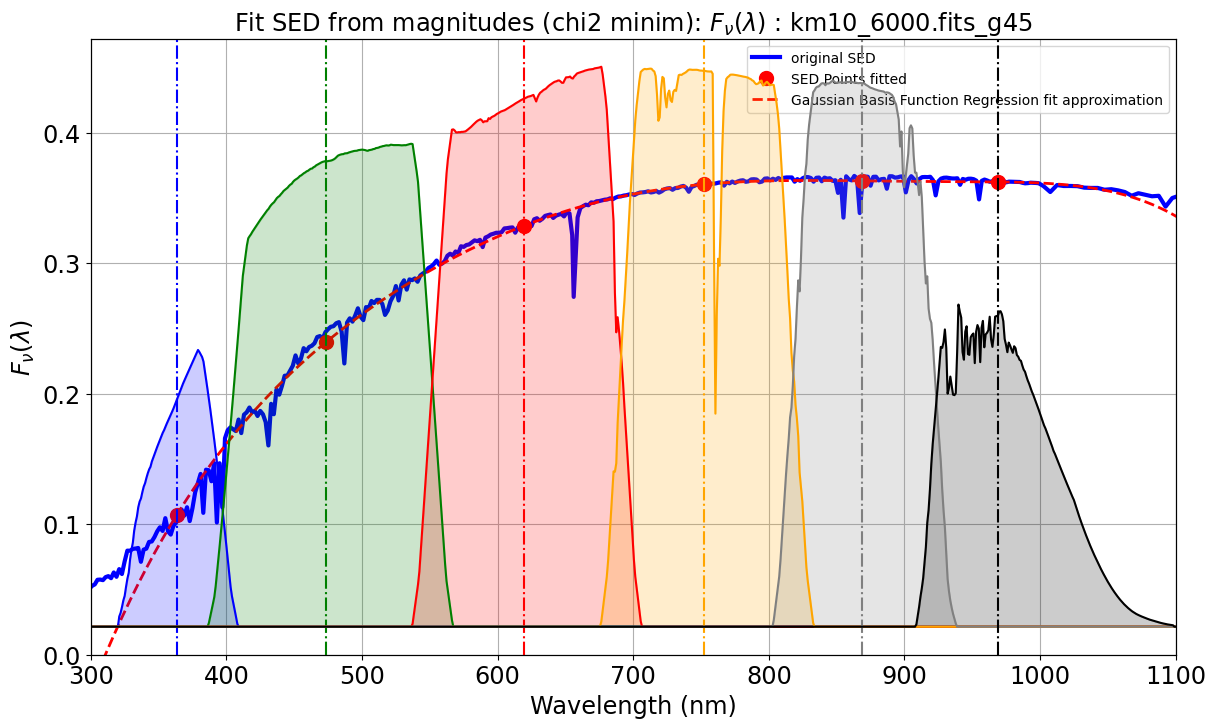

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  km10_7250.fits_g45 Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.244e-10 -3.535e-11 -1.403e-11  3.091e-11  1.197e-10
                4.405e-11]
           x: [ 1.852e-01  3.669e-01  3.965e-01  3.882e-01  3.621e-01
                3.536e-01]
        cost: 3.450583306798005e-20
         jac: [[ 5.958e+02 -4.605e+01 ...  6.005e+01 -1.573e+01]
               [ 1.774e+01  2.670e+02 ... -8.032e+00  2.296e+00]
               ...
               [-4.998e-01  1.567e+00 ...  2.708e+02  1.355e+01]
               [ 1.386e+01 -3.818e+01 ... -7.614e+01  3.552e+02]]
        grad: [ 1.336e-07 -2.151e-08  1.908e-08 -1.241e-08  4.339e-08
                1.363e-08]
  optimality: 7.731430412748194e-07
 active_mask: [0 0 0 0 0 0]
        nfev: 7
        njev: 7 {'chi2': 6.90116661359601e-20, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.18522478, 0.36689225, 0.39650313, 0.38820189, 0.36207013,
       0.35355744]), 'sig

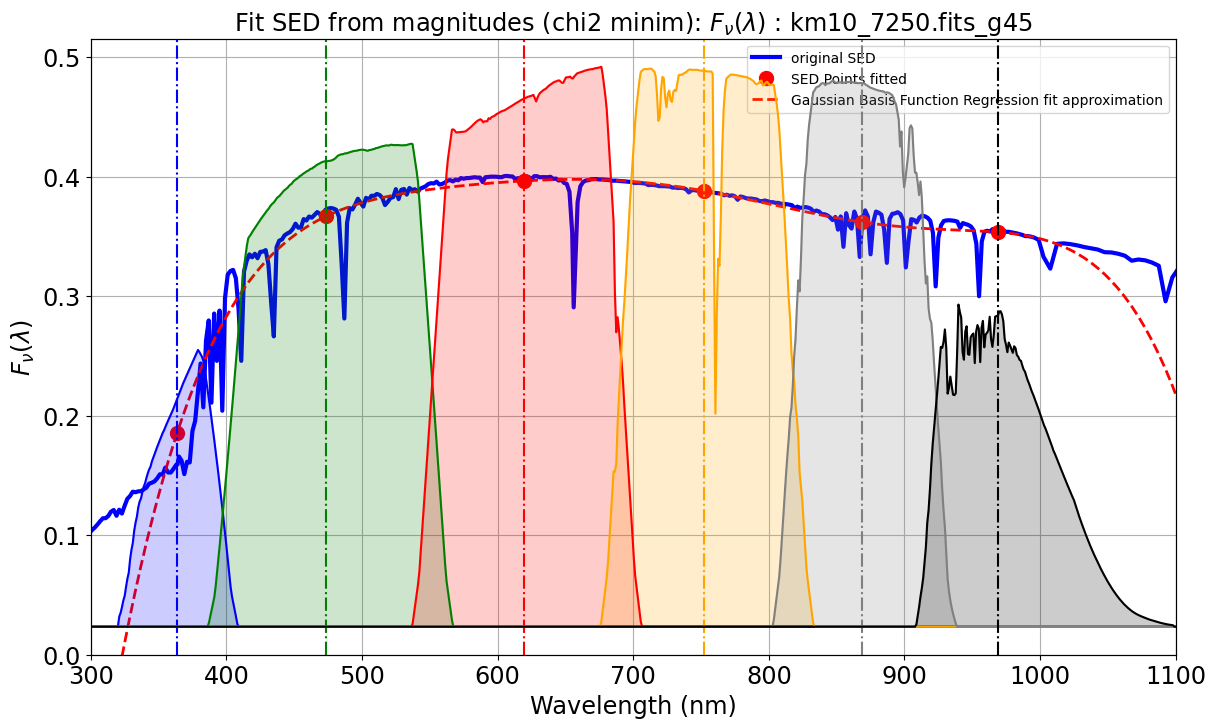

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  km10_6500.fits_g45 Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.165e-10  1.990e-11  1.634e-11  6.857e-11 -4.619e-11
               -4.707e-11]
           x: [ 1.414e-01  2.870e-01  3.549e-01  3.715e-01  3.628e-01
                3.569e-01]
        cost: 2.8301016063527975e-20
         jac: [[ 7.714e+02 -5.962e+01 ...  7.776e+01 -2.037e+01]
               [ 2.248e+01  3.383e+02 ... -1.019e+01  2.907e+00]
               ...
               [-4.993e-01  1.554e+00 ...  2.708e+02  1.354e+01]
               [ 1.365e+01 -3.761e+01 ... -7.499e+01  3.498e+02]]
        grad: [-1.672e-07  2.145e-08 -2.204e-08  4.450e-08 -2.463e-08
               -1.273e-08]
  optimality: 6.047448304168075e-06
 active_mask: [0 0 0 0 0 0]
        nfev: 7
        njev: 7 {'chi2': 5.660203212705595e-20, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.14139415, 0.28697079, 0.35487617, 0.37147568, 0.36281933,
       0.35690382]), 's

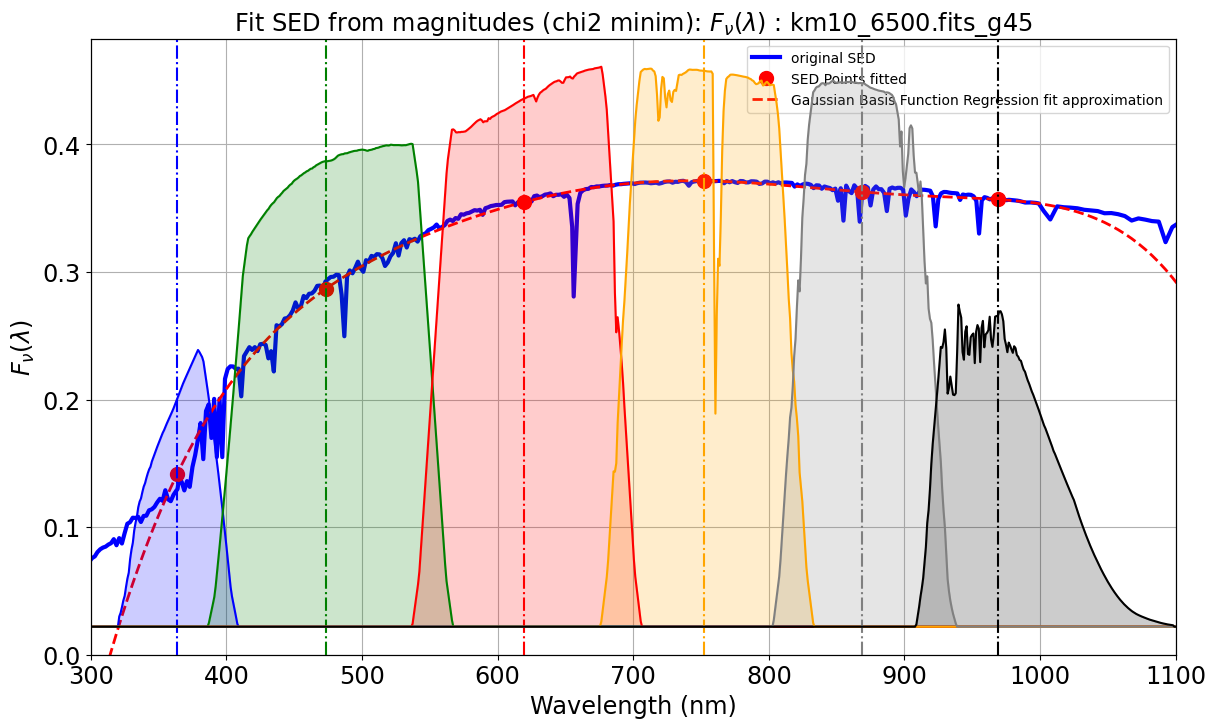

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  wd_He_5500_80.dat Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.060e-10 -2.558e-11  1.013e-11 -3.375e-12  0.000e+00
                4.441e-12]
           x: [ 7.281e-02  1.863e-01  3.029e-01  3.521e-01  3.638e-01
                3.587e-01]
        cost: 6.01711544066379e-21
         jac: [[ 1.448e+03 -1.116e+02 ...  1.457e+02 -3.813e+01]
               [ 3.398e+01  5.117e+02 ... -1.539e+01  4.407e+00]
               ...
               [-4.985e-01  1.559e+00 ...  2.708e+02  1.354e+01]
               [ 1.349e+01 -3.715e+01 ... -7.419e+01  3.462e+02]]
        grad: [ 1.527e-07 -2.490e-08  2.703e-08 -2.669e-08  1.546e-08
               -2.624e-09]
  optimality: 9.597291434570393e-07
 active_mask: [0 0 0 0 0 0]
        nfev: 8
        njev: 8 {'chi2': 1.203423088132758e-20, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.07280814, 0.18631805, 0.30287894, 0.35208544, 0.36375753,
       0.35874196]), 'sigm

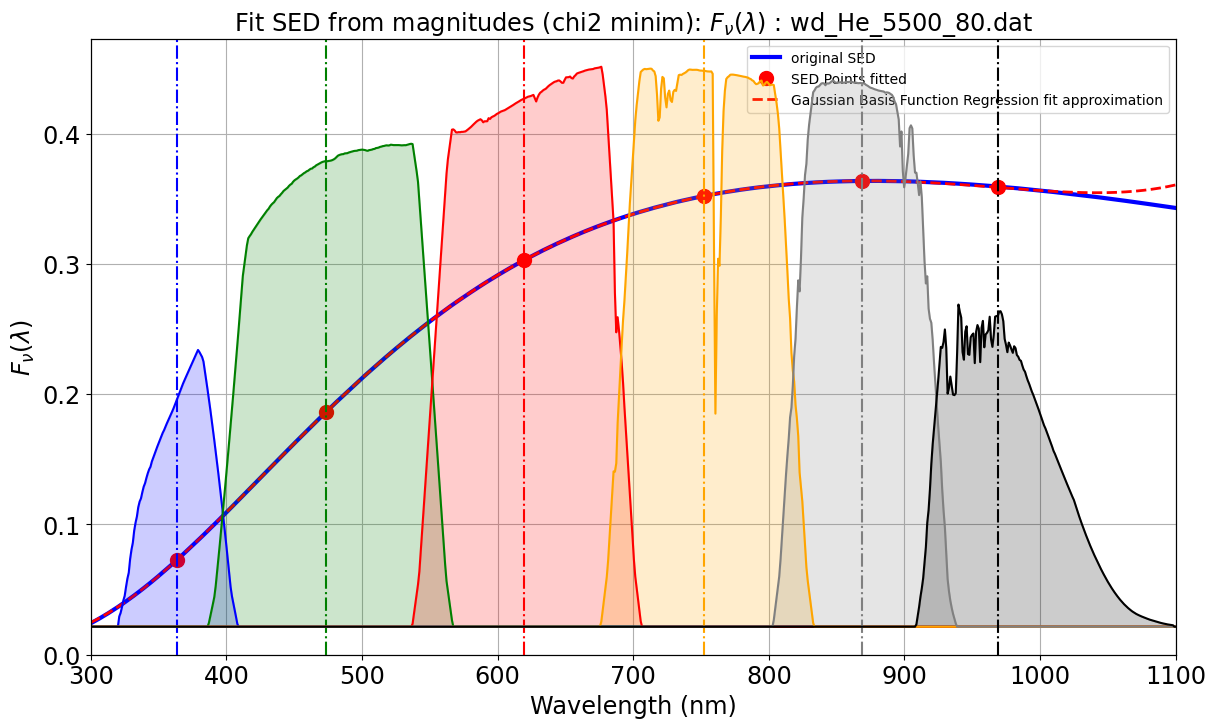

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  wd_H_5500_80.dat Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 9.059e-12  6.573e-12 -5.329e-12  5.329e-13  1.599e-12
                0.000e+00]
           x: [ 8.627e-02  1.853e-01  2.903e-01  3.439e-01  3.637e-01
                3.674e-01]
        cost: 7.825500179792437e-23
         jac: [[ 1.239e+03 -9.542e+01 ...  1.246e+02 -3.261e+01]
               [ 3.414e+01  5.141e+02 ... -1.546e+01  4.430e+00]
               ...
               [-4.984e-01  1.559e+00 ...  2.708e+02  1.354e+01]
               [ 1.318e+01 -3.628e+01 ... -7.244e+01  3.381e+02]]
        grad: [ 1.145e-08  2.419e-09  1.576e-10 -1.672e-09  1.461e-09
               -2.400e-10]
  optimality: 6.013530483508268e-08
 active_mask: [0 0 0 0 0 0]
        nfev: 8
        njev: 8 {'chi2': 1.5651000359584874e-22, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.08626609, 0.18528541, 0.29034542, 0.34391333, 0.36371049,
       0.36743138]), 'sig

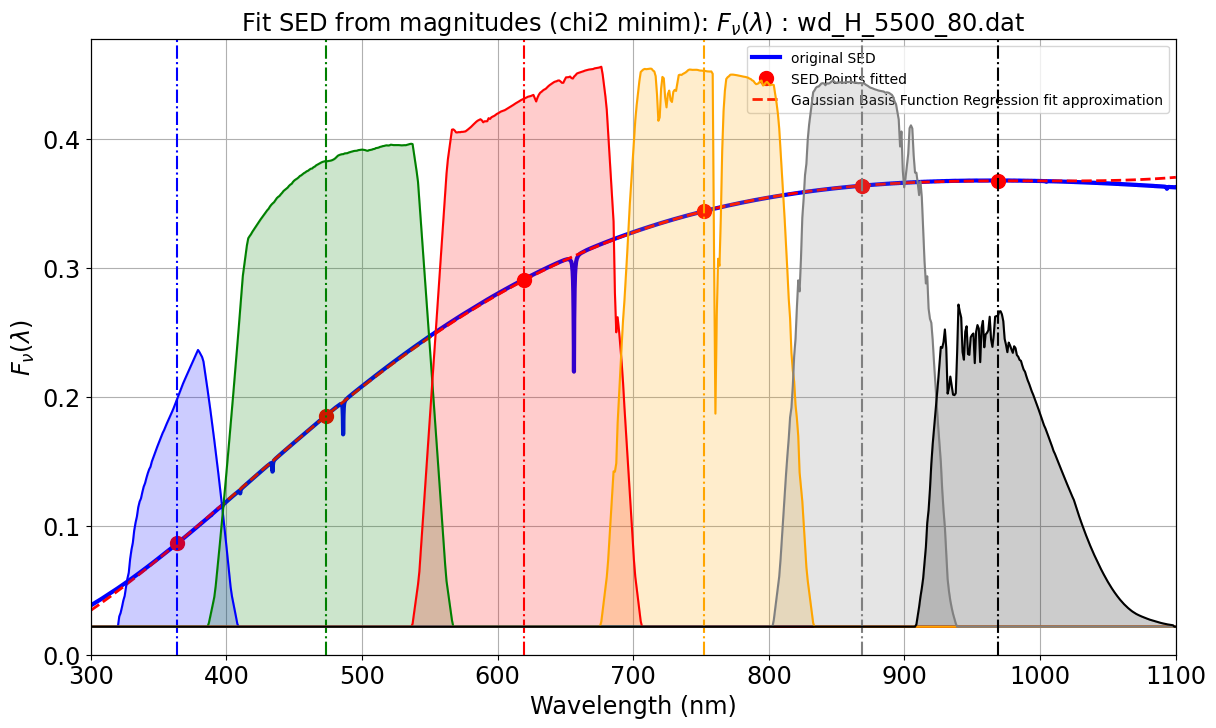

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  wd_He_15000_80.dat Fit Results ::       message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 3.553e-13  2.185e-11  3.340e-11  3.926e-11  5.720e-11
                3.766e-11]
           x: [ 8.083e-01  7.204e-01  5.583e-01  4.408e-01  3.621e-01
                3.098e-01]
        cost: 3.91189812011858e-21
         jac: [[ 1.364e+02 -1.051e+01 ...  1.372e+01 -3.591e+00]
               [ 8.884e+00  1.338e+02 ... -4.023e+00  1.153e+00]
               ...
               [-5.000e-01  1.557e+00 ...  2.708e+02  1.354e+01]
               [ 1.577e+01 -4.341e+01 ... -8.668e+01  4.045e+02]]
        grad: [ 7.921e-10  1.625e-09  8.069e-09  1.063e-08  1.283e-08
                1.597e-08]
  optimality: 4.89060243011902e-09
 active_mask: [0 0 0 0 0 0]
        nfev: 6
        njev: 6 {'chi2': 7.82379624023716e-21, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.8082999 , 0.72036725, 0.55827812, 0.44081717, 0.3620532 ,
       0.30984202]), 'sigma

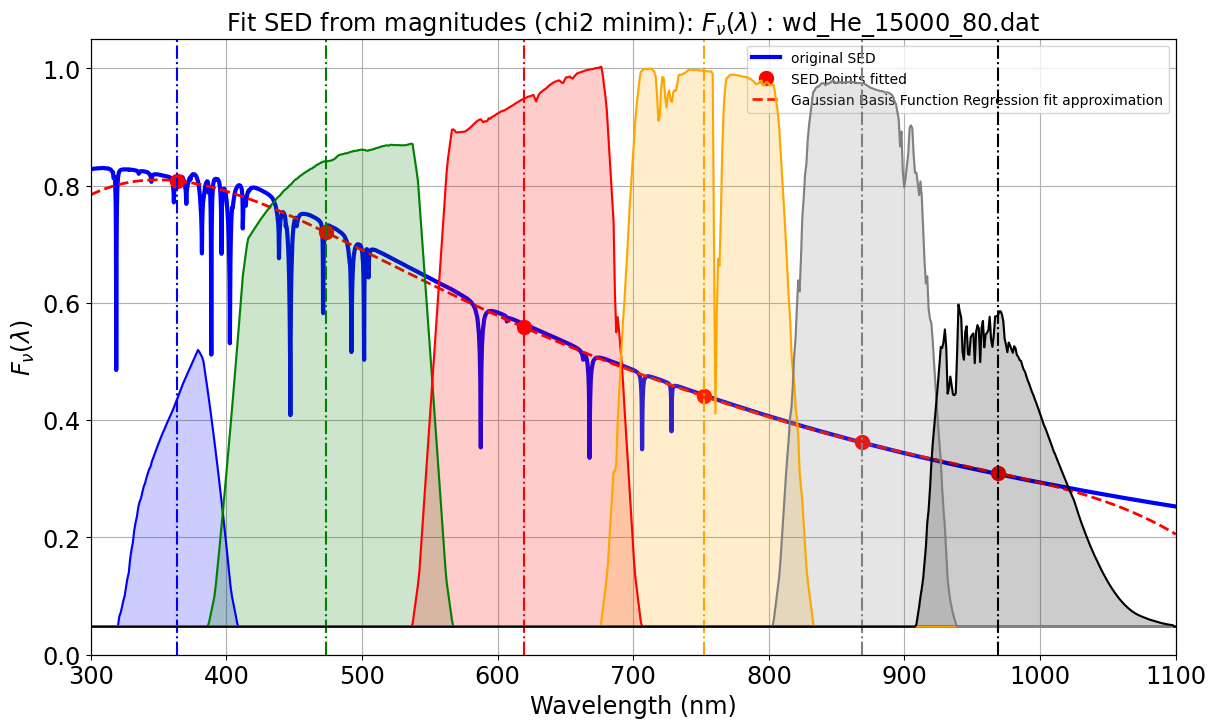

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  wd_H_50000_80.dat Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 8.704e-12  7.798e-11  5.826e-11  7.105e-11  3.713e-11
                8.633e-11]
           x: [ 1.623e+00  1.081e+00  6.739e-01  4.734e-01  3.618e-01
                2.907e-01]
        cost: 1.1715893951634692e-20
         jac: [[ 6.801e+01 -5.239e+00 ...  6.840e+00 -1.791e+00]
               [ 5.842e+00  8.801e+01 ... -2.646e+00  7.549e-01]
               ...
               [-4.995e-01  1.558e+00 ...  2.708e+02  1.354e+01]
               [ 1.650e+01 -4.542e+01 ... -9.071e+01  4.233e+02]]
        grad: [ 2.433e-09  3.299e-09  1.369e-08  1.730e-08  3.226e-09
                3.699e-08]
  optimality: 1.0620348115150326e-08
 active_mask: [0 0 0 0 0 0]
        nfev: 7
        njev: 7 {'chi2': 2.3431787903269384e-20, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([1.62310177, 1.08113468, 0.67391358, 0.47344075, 0.36180219,
       0.29071937]), '

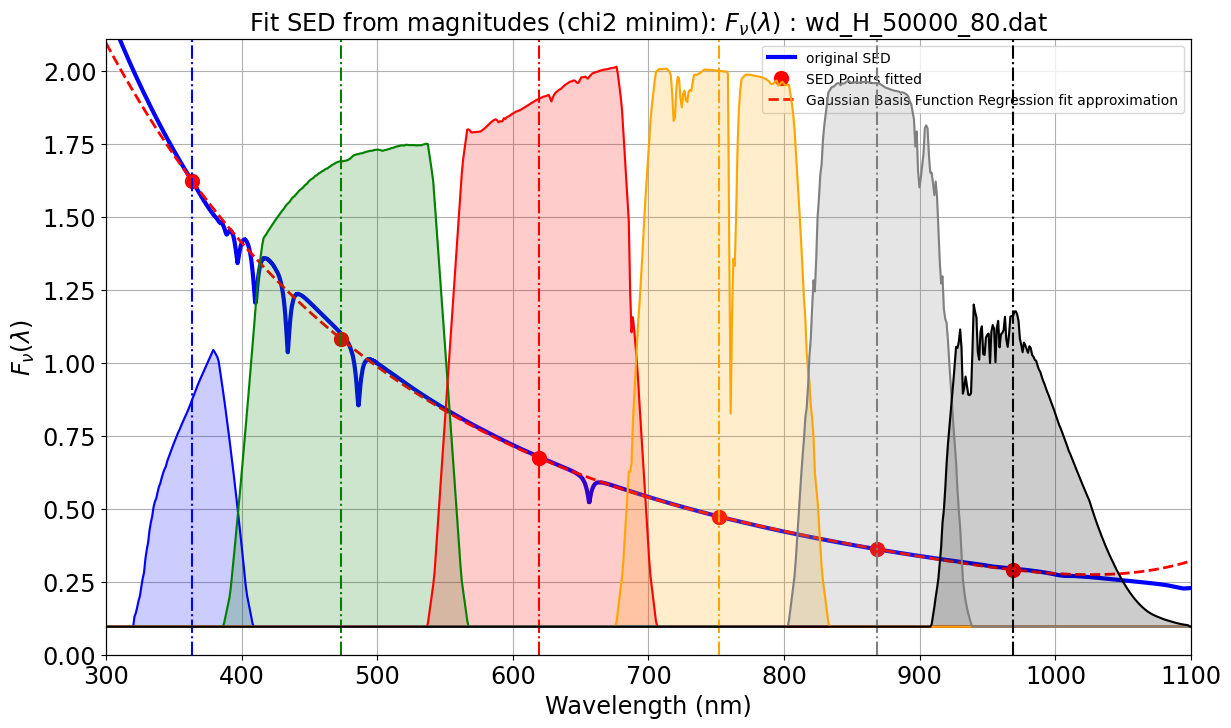

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  wd_He_10000_80.dat Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-5.329e-13 -3.553e-13 -5.684e-12 -2.611e-11 -1.599e-11
               -4.938e-11]
           x: [ 4.630e-01  5.146e-01  4.781e-01  4.164e-01  3.625e-01
                3.225e-01]
        cost: 1.704412871820518e-21
         jac: [[ 2.372e+02 -1.827e+01 ...  2.386e+01 -6.246e+00]
               [ 1.248e+01  1.879e+02 ... -5.651e+00  1.619e+00]
               ...
               [-4.955e-01  1.562e+00 ...  2.709e+02  1.354e+01]
               [ 1.513e+01 -4.165e+01 ... -8.316e+01  3.881e+02]]
        grad: [-8.719e-10  1.957e-09 -3.632e-09 -7.250e-09 -7.031e-10
               -1.935e-08]
  optimality: 6.962403333527624e-07
 active_mask: [0 0 0 0 0 0]
        nfev: 6
        njev: 6 {'chi2': 3.408825743641036e-21, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.46295887, 0.51457222, 0.47813491, 0.41637436, 0.36251827,
       0.32253316]), 'si

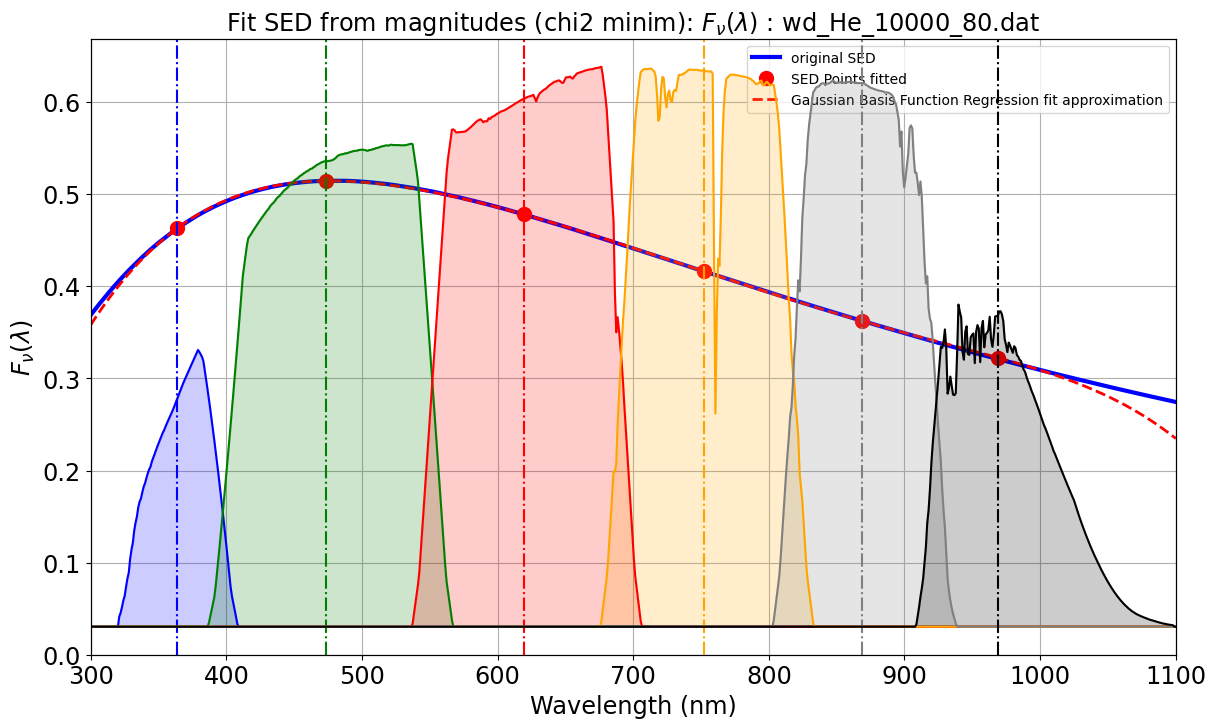

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  wd_H_100000_80.dat Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 7.105e-13 -1.592e-10 -9.219e-11 -2.267e-10 -2.995e-10
               -2.371e-10]
           x: [ 1.786e+00  1.121e+00  6.833e-01  4.750e-01  3.621e-01
                2.868e-01]
        cost: 1.1557112028631807e-19
         jac: [[ 6.178e+01 -4.759e+00 ...  6.215e+00 -1.625e+00]
               [ 5.612e+00  8.449e+01 ... -2.532e+00  7.337e-01]
               ...
               [-4.948e-01  1.569e+00 ...  2.709e+02  1.355e+01]
               [ 1.656e+01 -4.555e+01 ... -9.098e+01  4.247e+02]]
        grad: [-4.623e-09 -3.485e-09 -2.690e-08 -5.656e-08 -6.271e-08
               -1.046e-07]
  optimality: 3.768804817212794e-06
 active_mask: [0 0 0 0 0 0]
        nfev: 7
        njev: 7 {'chi2': 2.3114224057263614e-19, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([1.78564364, 1.12117781, 0.68329142, 0.47503186, 0.36208   ,
       0.28682498]), '

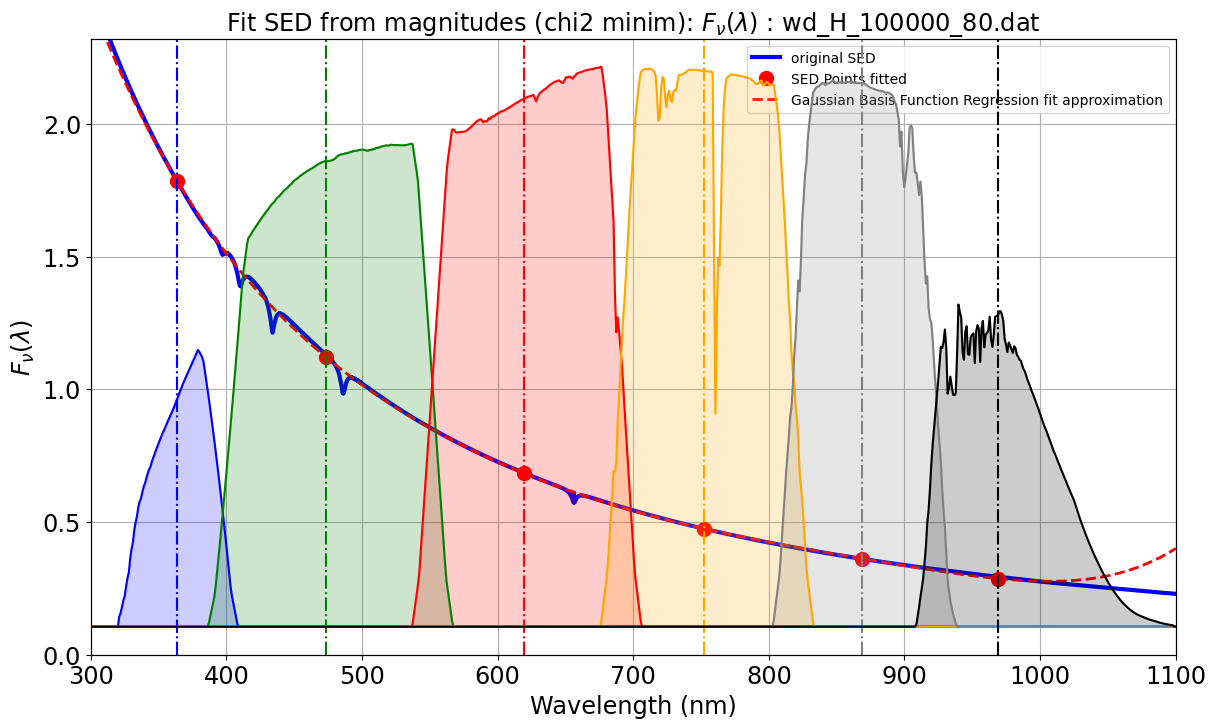

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  wd_H_15000_80.dat Fit Results ::       message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-4.228e-11  9.983e-11 -3.537e-10 -8.136e-11  4.636e-11
                1.588e-10]
           x: [ 5.961e-01  7.563e-01  5.718e-01  4.463e-01  3.610e-01
                3.149e-01]
        cost: 8.541296787971879e-20
         jac: [[ 1.865e+02 -1.437e+01 ...  1.876e+01 -4.914e+00]
               [ 8.638e+00  1.301e+02 ... -3.957e+00  1.097e+00]
               ...
               [-4.915e-01  1.566e+00 ...  2.708e+02  1.353e+01]
               [ 1.608e+01 -4.424e+01 ... -8.841e+01  4.124e+02]]
        grad: [-4.253e-09  3.517e-09 -5.517e-08 -1.507e-08 -4.353e-09
                6.671e-08]
  optimality: 1.9717010299447182e-06
 active_mask: [0 0 0 0 0 0]
        nfev: 6
        njev: 6 {'chi2': 1.7082593575943758e-19, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.59608235, 0.7563499 , 0.57182203, 0.44628647, 0.36102599,
       0.31491123]), 's

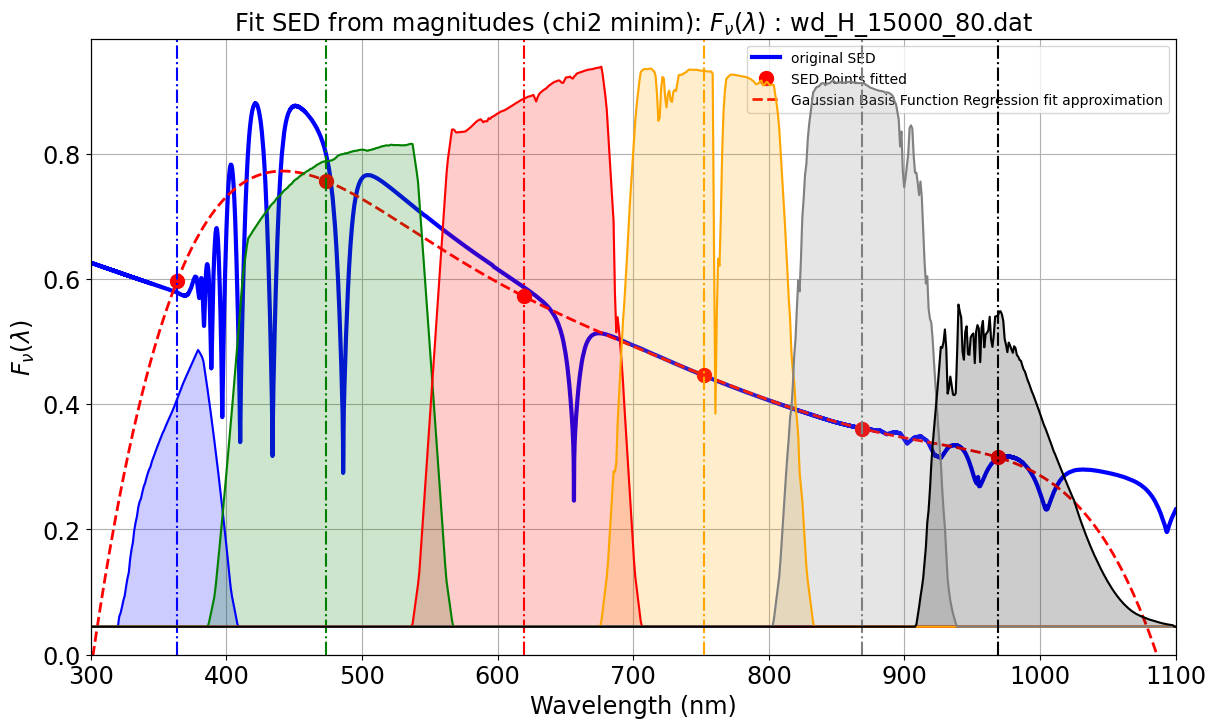

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_42738/1914580387.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_per_deg = chi2/ndeg


SED :  Flat Fit Results ::       message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 0.000e+00 -1.776e-13  1.776e-13  0.000e+00  1.776e-13
                0.000e+00]
           x: [ 3.631e-01  3.631e-01  3.631e-01  3.631e-01  3.631e-01
                3.631e-01]
        cost: 4.733165431326071e-26
         jac: [[ 3.023e+02 -2.329e+01 ...  3.041e+01 -7.960e+00]
               [ 1.750e+01  2.636e+02 ... -7.928e+00  2.271e+00]
               ...
               [-4.983e-01  1.558e+00 ...  2.708e+02  1.354e+01]
               [ 1.333e+01 -3.670e+01 ... -7.328e+01  3.420e+02]]
        grad: [-3.403e-12 -4.396e-11  4.482e-11  4.004e-12  4.980e-11
                1.856e-12]
  optimality: 1.5801554602906455e-09
 active_mask: [0 0 0 0 0 0]
        nfev: 2
        njev: 2 {'chi2': 9.466330862652142e-26, 'ndeg': 0, 'chi2_per_deg': inf, 'popt': array([0.3631, 0.3631, 0.3631, 0.3631, 0.3631, 0.3631]), 'sigmas': array([0.00345288, 0.00379109, 0.0037

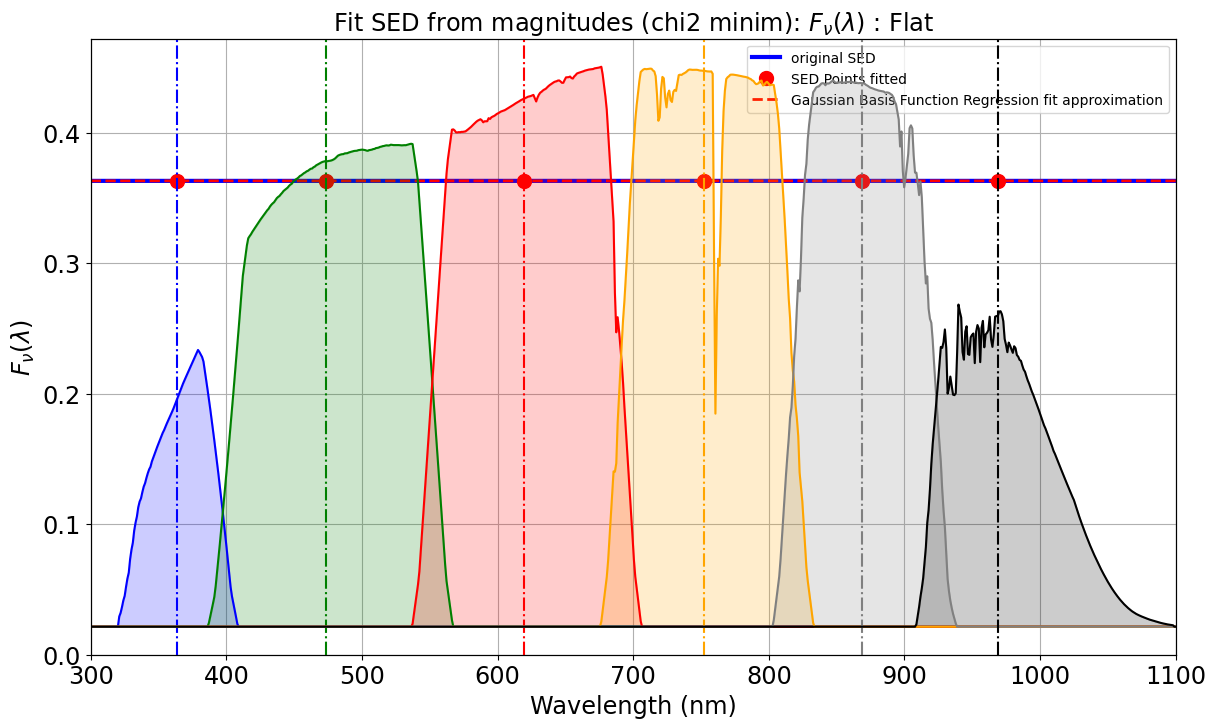

In [64]:
for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    the_sed_name = os.path.basename(the_sed.name)
    wavel,fnu = the_sed.get_sed_fnu()

    # compute the magnitudes for that SED
    mag_true = {}
    for index,f in enumerate(filter_tagnames):
        mag_true[f] = the_sed.calc_mag(pc.bandpass_total_std[f])

    # fit the SED points
    xdata = wl0
    ydata = mag_true
    ydataerr = mag_true_err
    res_fit,fit_dict = the_fit.fit(params0 = params0 ,bounds = bounds,xdata = xdata ,ydata = mag_true ,yerrdata=ydataerr,wlrange=wavel)

    print("SED : ",the_sed_name,"Fit Results :: ",res_fit,fit_dict )
    
    
    # does the gaussian process fit from the fitted SED
    #yfit = FitGaussianProcess(wl0,fit_dict["popt"],wlfit=wavel)
    yfit = FitGaussianBasisFunctionRegression(wl0,fit_dict["popt"],0.05*fit_dict["popt"],wlfit=wavel)
   
    # calculate the approximated SED
    the_sed_approx = Sed(wavelen=wavel, fnu=yfit, name="fGPv2_"+the_sed_name)    

    
    # plot
    PlotSEDPointsFitResults(wl0,fit_dict["popt"],the_sed,the_sed_approx)
    
    